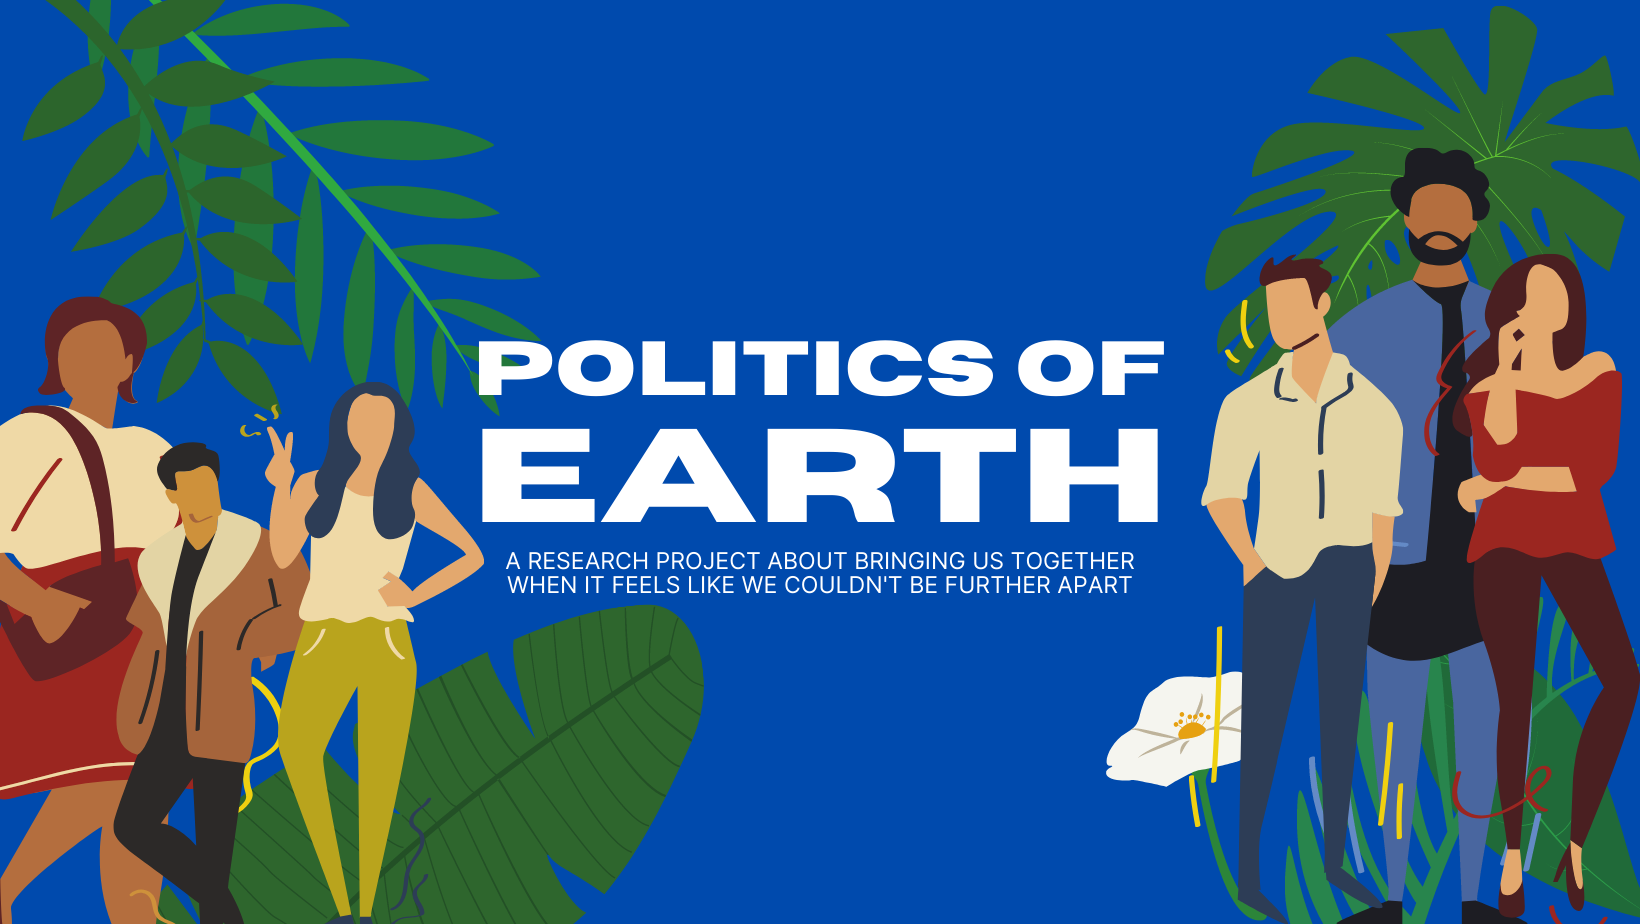

# **Background**

Regardless of where you fall on the political spectrum, and regardless of where in the world you live, you likely have felt the impacts of political divisiveness, especially over the last several years. As the stressors being placed on the world increase, so too do the tensions democracies across the world are feeling. Add to this the echo chambers created by social media, and it becomes easy to forget or lose sight of one another’s point of view.<br><br>
Two- and three-party systems — the modus operandi of many democracies — aren’t serving the citizenry. We are forced to build ad hoc political coalitions in order to ensure “we” win office, or “they” are forced out. This is why every election cycle there is a focus on “moderates” and “independents” — voters that change allegiances each election, and on which constituencies might be won over THIS cycle.<br><br>
Here’s the problem: that doesn’t actually help anyone.<br><br>
Those who have their feet firmly planted in a specific ideology have to make concessions before a single ballot is cast in order to woo new social or demographic groups into uneasy alliances.<br><br>
Those who are being fought over — those in “the middle” — are being lumped together in the same haphazard way that popcorn and Fruit-by-the-Foot are both lumped into that category of “snacks.” Their unique wants and needs get watered down because “moderate” has become a synonym for “other.” It doesn’t make sense!<br><br>
What would happen if we understood what the citizens of Earth ACTUALLY wanted, in an empirical way? What if we could concretely identify the political ideologies that naturally cluster together in PRACTICE instead of in THEORY, and formed more representative political coalitions based on those clusters that represented our interests both at home AND abroad?

# **The Project**

We sought to use publicly sourced data from our survey to do several things:

*  Create an unsupervised learning model to determine the number of political “clusters” that exist in the world today. To be clear, these clusters would identify people who share strong beliefs across social and economic spectrums, with a goal to maximize the number of clusters without sacrificing the integrity of the model.
*   Create a supervised learning model that would predict the probability that a new participant is in a given cluster.
*   Create a publicly available website where future participants would be able to take the above-linked survey, and get real-time results on which political cluster they belong to, and based on which beliefs.
*   Use the data sourced from the website test to further enrich the unsupervised learning model, making it more accurate over time.

## What were our Hypotheses (H1's)?


* We hypothesized that we would be able to clearly identify some number of political “clusters” that could be the basis of new, international political coalitions.
* We hypothesized that participants in each nation would be evenly distributed across those coalitions.
* We hypothesized that for any cluster, they would be able to form at least one single-issue-based alliance with any other cluster.
* Specific to the United States, we hypothesized that the proposed coalitions would not naturally align with the current two-party system.

## But Why the Whole World?

There are a few reasons for this. <br><br>
We believed that as we move towards a global economy, we should also head toward positioning our political beliefs globally. This doesn’t mean being united under a single government (necessarily), but it does mean having the same conversations on the local, grass-roots level that we’re having on the international stage. This should increase diplomacy naturally while also helping to re-enfranchise people who no longer feel represented by the political process.<br><br>
We were curious to see how results change when you cluster the whole world versus individual countries. For example, are so-called “conservatives” the same everywhere, or how vastly does “conservative” ideology change from nation to nation?<br><br>
We were curious to see how closely clustered the results from a given country are. For example, would all citizens from a given country be closely clustered regardless of political ideology?<br><br>
To the best of our knowledge, no similar studies have been conducted on an international scale.

#**Methodology**

We gathered data from participants using a survey, and then ran relevant experiements to uncover possible clusters:
* 64 questions spanning 11 political dimensions (Domestic Policy, Foreign Policy, Race/Gender/Sexual Orientation, etc.)
* A free-form text box for each political dimension for eventual language analysis
* We ran cluster analysis on each political dimension, and on four “decision-making” dimensions based on dichotomies found in psychology & ethics
* We used a stepwise selection process so that only statistically relevant questions were considered


#**Import Libraries & Functions**

In [1]:
!pip install kneed

In [2]:
#pandas
import pandas as pd 
from pandas import concat
from pandas.plotting import lag_plot, autocorrelation_plot
pd.set_option('max_colwidth',150)

#vizualization libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline 
import seaborn as sns
import missingno as msno
import matplotlib.colors as mcolors

#google
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

#scipy
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

#sci-kit learn
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, mean_squared_error, precision_score, recall_score, roc_auc_score, roc_curve, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler 

#stasmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

#misc
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from kneed import KneeLocator

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def make_confusion_matrix(cf,group_names=None,categories='auto',count=True,
                          percent=True,cbar=False,xyticks=True,cmap='Blues',
                          title='Confusion Matrix'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    
    @params
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'              
    title:         Title for the heatmap. Default is None.
    
    @outputs
    outputs as part of run_model()
    '''

    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    if xyticks==False:
        categories=False

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8.33,8.33))
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories);

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show();

In [4]:
def gsheet_import(url,sheet):
    '''
    Loads the requested Google Sheet, and provides its shape, summary information, and count of null values
    
        @params
        url:        Google Sheet URL
        sheet:      Sheet to pull data frome
        
        @output
        a pd.Dataframe
    '''
    auth.authenticate_user()
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    wb = gc.open_by_url(url)
    sheet = wb.worksheet(sheet)
    data = sheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.iloc[1:]
    df = df.replace(r'^\s*$', np.nan, regex=True)

    print('DATAFRAME SHAPE')
    print("================================================================================")
    print(df.shape)
    print("")
    print('DATA SUMMARY')
    print("================================================================================")
    print(df.info())
    print("")
    print("VALUE COUNTS FOR COLUMNS WITH NULL VALUES")
    print("================================================================================")      
    null_cols = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            null_cols.append(col)
    for col in null_cols:
        print(col, "/ VALUE COUNTS")
        print("----------------------------------------")
        print(df[col].value_counts(dropna=False))  
        print("")
    print("")
    print("MISSING VALUES VISUALIZATION")
    print("================================================================================") 
    msno.bar(df, figsize=(10,5))
    return df

In [5]:
def run_model(model, X_train, X_test, y_train, y_test, target_names):  
    '''
    Loads a model, training and test data, and provides the model hyperparameters, as well as several accuracy metrics
    
        @params
        model:                                  the instantialted model, such as the logreg in the code "logreg = LogisticRegressionCV()"
        X_train, X_test, y_train, and y_test:   the resultant datasets from the test_train_split action
        
        @output
        model hyper parameters
        accuracy, r-squared, rmse
        classification matrix
        confusion matrix
    '''
    target_names = target_names
    log = model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    training_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_test, y_pred_test)

    print("")
    print('MODEL HYPERPARAMETERS')
    print("================================================================================")
    print(log)
    print("")
    print("")
    print('ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR')
    print("================================================================================")
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print('Training R-Squared: ', model.score(X_train, y_train))
    print('Training Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    print("")
    print("Validation accuracy: {:.4}%".format(val_accuracy * 100)) 
    print('Validation R-Squared: ', model.score(X_test, y_test))
    print('Validation Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print("")
    print("")
    print("CLASSIFICATION REPORT AND CONFUSION MATRIX")
    print("================================================================================")
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    

    cm = confusion_matrix(y_test, y_pred_test)
    make_confusion_matrix(cm, categories=target_names)

In [6]:
def validate_changes(df):
    '''
    Loads the requested df, and provides its shape and count of null values; should be run after initial transformation
    
        @params
        df: pd.DataFrame
        
        @output
        summary data
    '''
    print('DATAFRAME SHAPE')
    print("================================================================================")
    print(df.shape)
    print("")
    print("COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION")
    print("(Should Produce No Results Below Line)")
    print("================================================================================")      
    null_cols = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            null_cols.append(col)
    for col in null_cols:
        print(col, "VALUE COUNTS")
        print("----------------------------------------")
        print(df[col].value_counts(dropna=False))  
        print("")
    print("")
    return df.head(1)

In [7]:
def find_k(X, kmin, kmax):
    '''
    Finds the optimal k
    
        @params
        X:          candidate features
        kmin:       minimum acceptable k
        kmax:       maximum acceptable l
        
        @output
        three charts showing potential k options
    '''
    plt.style.use("fivethirtyeight")
    kmin = kmin
    kmax = kmax

    SSE = []
    K = range(kmin,kmax+1)

    for k in K:
        kmeans = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500, 
                        random_state=10)
        kmeans = kmeans.fit(X)
        SSE.append(kmeans.inertia_)

    kl = KneeLocator(K, SSE, curve="convex", direction="decreasing")

    sil = []
    Ksil = range(kmin+1,kmax+1)

    for k in Ksil:
        kmeans = KMeans(n_clusters=k, init="k-means++", n_init=50, max_iter=500, 
                        random_state=10)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        sil.append(score)

    ymax = max(sil)
    xpos = sil.index(ymax)
    xmax = Ksil[xpos]

    figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,5))

    ax1.plot(K, SSE)
    ax1.axvline(kl.elbow, linestyle='--', linewidth=3, color='green')
    ax1.set_xticks(K)
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia (SSE)')
    ax1.title.set_text('Elbow Method For Optimal k')

    ax2.plot(Ksil, sil)
    ax2.axvline(xmax, linestyle='--', linewidth=3, color='green')
    ax2.set_xticks(Ksil)
    ax2.set_xlabel("Number of Clusters (k)")
    ax2.set_ylabel("Silhouette Coefficient")
    ax2.title.set_text('Silhouette Method For Optimal k')

    np.set_printoptions(precision=4, suppress = True)
    Z = linkage(X,'ward')
    dendrogram(Z, truncate_mode='lastp', p=(len(X)/2), leaf_rotation=45, show_contracted=True)
    ax3.set_xlabel('Cluster Size')
    ax3.set_ylabel('Euclidian Distance')
    ax3.title.set_text('Trunctated Hierarchal Clustering Dendrogram')

In [8]:
def cluster(X, n_clusters):
    '''
    Plots 2 PCAs
    
        @params
        X:          candidate features
        n_clusters: number of clusters
        
        @output
        visualization of two PCAs
    '''
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=50, 
                    max_iter=500, random_state=10)
    kmeans = kmeans.fit(X)
    predictions = kmeans.predict(X)
    unique, counts = np.unique(predictions, return_counts=True)
    counts = counts.reshape(1, n_clusters)

    columns = []
    target_list = []
    clust_count = range(0, n_clusters)

    for c in clust_count:
        columns.append("Cluster {}".format(c))
        target_list.append(c+1)

    df_cluster = pd.DataFrame(counts, columns = columns)

    y = predictions
    target_names = columns
    
    pca = PCA(n_components=2, random_state=10)
    X_pca = pca.fit_transform(X)

    # Store results of PCA in a data frame
    result = pd.DataFrame(X_pca, columns=['PCA%i' % i for i in range(2)])
    cmap = mcolors.ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    n = len(unique)
    norm = mcolors.BoundaryNorm(np.arange(n+1)-0.5, n)

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8.33,5))
    sc = plt.scatter(result['PCA0'], result['PCA1'], c=predictions, cmap=cmap, norm=norm, s=100)
    plt.colorbar(sc, ticks=unique)
    plt.xlabel("PCA 0")
    plt.ylabel("PCA 1")
    plt.title('Estimated Clustering Based on Two Principal Components')

    plt.show();

    print('Explained variance ratio (first two components): %s' %str(pca.explained_variance_ratio_))
    return df_cluster

In [9]:
def apply_clusters(X, n_clusters, topic, topic_df):
    '''
    Applies clusters
    
        @params
        X:          candidate features
        n_clusters: number of clusters
        topic:      will output "topic_cluster" column
        topic_df:   specific topic df to append information to
        
        @output
        pd.DataFrame
    '''
    
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init=50, 
                    max_iter=500, random_state=10)
    kmeans = kmeans.fit(X)
    predictions = kmeans.predict(X)
    
    df['%s_cluster' %str(topic)] = predictions
    topic_df['%s_cluster' %str(topic)] = df['%s_cluster' %str(topic)]

In [10]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.01, threshold_out = 0.05, 
                       verbose=True):
    """
    Perform a forward-backward feature selection based on p-value from statsmodels.api.OLS
    @params:
        X:  candidate features
        y:              list-like with the target
        initial_list:   list of features to start with (column names of X)
        threshold_in:   include a feature if its p-value < threshold_in
        threshold_out:  exclude a feature if its p-value > threshold_out
        verbose:        whether to print the sequence of inclusions and exclusions
    @output:
        list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#Importing & Cleaning Data

DATAFRAME SHAPE
(72, 80)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 1 to 72
Data columns (total 80 columns):
 #   Column                                                                                                                                                                                                                                               Non-Null Count  Dtype 
---  ------                                                                                                                                                                                                                                               --------------  ----- 
 0   Timestamp                                                                                                                                                                                                                                            72 non-null     object
 1   Which country do you currently vot

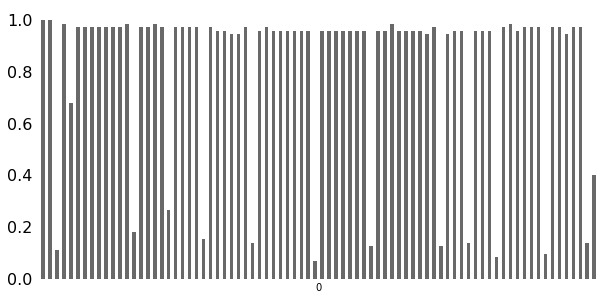

In [11]:
df = gsheet_import('https://docs.google.com/spreadsheets/d/1lnddfjwV3ZGpUOJRnPL-njLduoUKvZejBLQoWK6idyQ/edit#gid=490130400',
              'Form Responses 1')

In [12]:
#change yes/no and true/false to 0/1
df.replace(('Strongly Disagree', 'Disagree', 'Slightly Disagree', 'Unsure/No Opinion', 
            'Slightly Agree', 'Agree', 'Strongly Agree'), (-3,-2,-1,0,1,2,3), inplace=True)

#change yes/no and true/false to 1/0
df.replace(('Yes', 'No'), (1,0), inplace=True)

#drop values with more than 10% NaNs:
df = df.dropna(thresh=len(df) * .9, axis=1)

#fill remaining NaNs with median:
df = df.fillna(df.median())

#simplify column names
df.columns = df.columns.str.replace("For each of the statements below, please indicate how strongly you agree or disagree.", "")

#drop non-numeric columns
df.drop(['Timestamp',"Which country do you currently vote in? If you don't currently vote, select the country you WOULD vote in."], 
        axis=1, inplace=True)

#confirm changes
validate_changes(df)

DATAFRAME SHAPE
(72, 64)

COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION
(Should Produce No Results Below Line)



0  Did you vote in the last national election? We define a national election as any election that ends in the selection of a president or prime minister.  ...  RELIGION:  [It is important that my child’s school instills religious values]
1                                                                                                                                                    1.0   ...                                                                           -3.0

[1 rows x 64 columns]

# Exploratory Data Analaysis

In [13]:
X = df.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

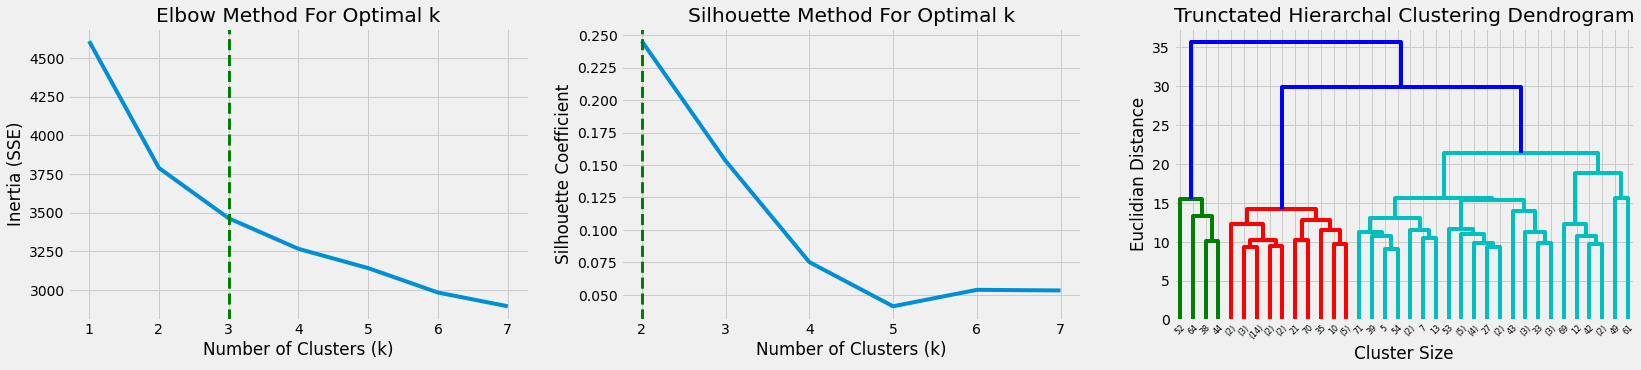

In [14]:
find_k(X, 1, round(len(df)/10))

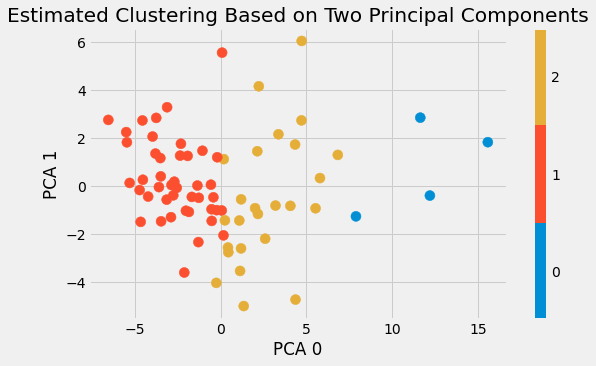

Explained variance ratio (first two components): [0.2761 0.0706]


Cluster 0  Cluster 1  Cluster 2
0          4         43         25

In [15]:
cluster(X, 3)

#**Political Dimensions**

## Domestic Policy



In [16]:
dp_filter = [col for col in df if col.startswith('DOMESTIC POLICY:')]
domestic_df = df[dp_filter]
X_dp = domestic_df.values
scaler = StandardScaler()
X_dp = scaler.fit_transform(X_dp)

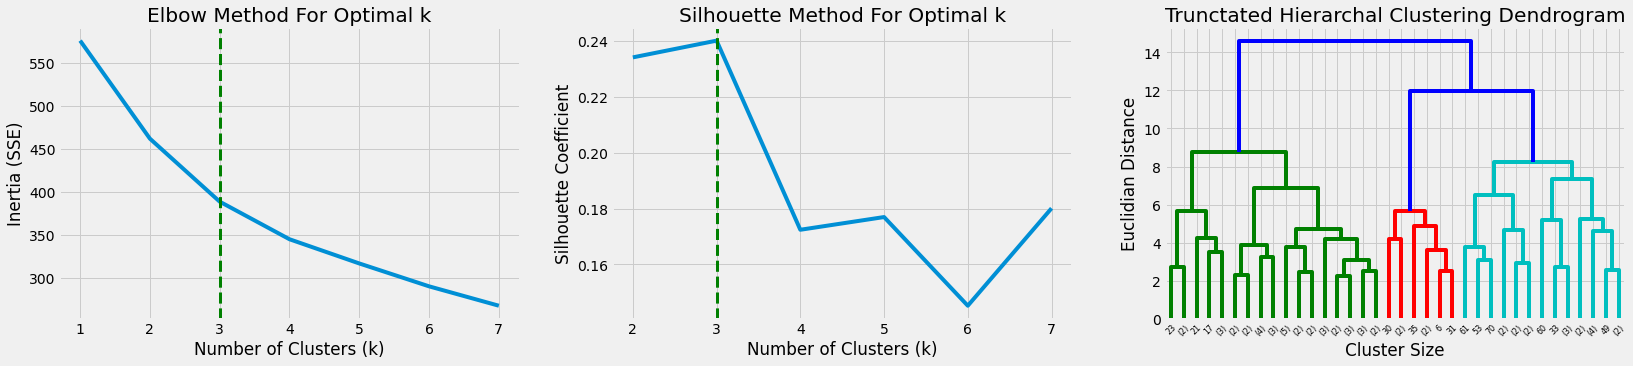

In [17]:
find_k(X_dp, 1, round(len(domestic_df)/10))

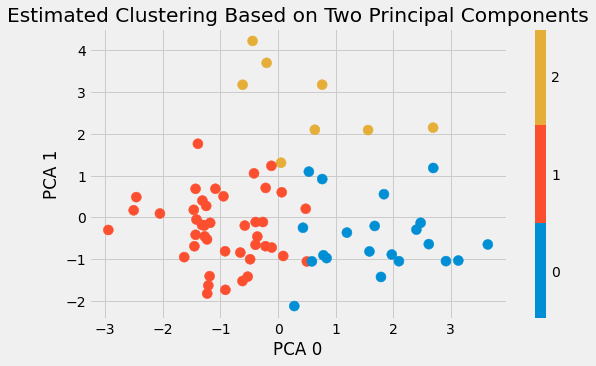

Explained variance ratio (first two components): [0.2706 0.2028]


Cluster 0  Cluster 1  Cluster 2
0         21         43          8

In [18]:
cluster(X_dp, 3)

In [19]:
apply_clusters(X_dp, 3, "domestic", domestic_df)

In [20]:
results = domestic_df.groupby(['domestic_cluster']).median()
results

0                 DOMESTIC POLICY:  [There is now a worrying blurred line between information and entertainment]  ...  DOMESTIC POLICY:  [Charity is better than social security programs as a means of helping the genuinely disadvantaged]
domestic_cluster                                                                                                  ...                                                                                                                       
0                                                                                                            2.0  ...                                                                                                                    0.0
1                                                                                                            2.0  ...                                                                                                                   -3.0
2                                                                                                            1.0  ...                                                                                                                    0.0

[3 rows x 8 columns]

In [21]:
X = domestic_df.drop(['domestic_cluster'], axis=1)
y = domestic_df['domestic_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['DOMESTIC POLICY:  [Possessing marijuana for personal use should not be a criminal offense]', 'DOMESTIC POLICY:  [Taxpayers should not be expected to financially support any theatres or museums that cannot survive on a commercial basis]', 'DOMESTIC POLICY:  [The death penalty should be an option for the most serious crimes]', 'DOMESTIC POLICY:  [Basic utilities like roads and electricity should be publicly owned]']


In [22]:
domestic_df = domestic_df[result]

X_dp = domestic_df.values
scaler = StandardScaler()
X_dp = scaler.fit_transform(X_dp)

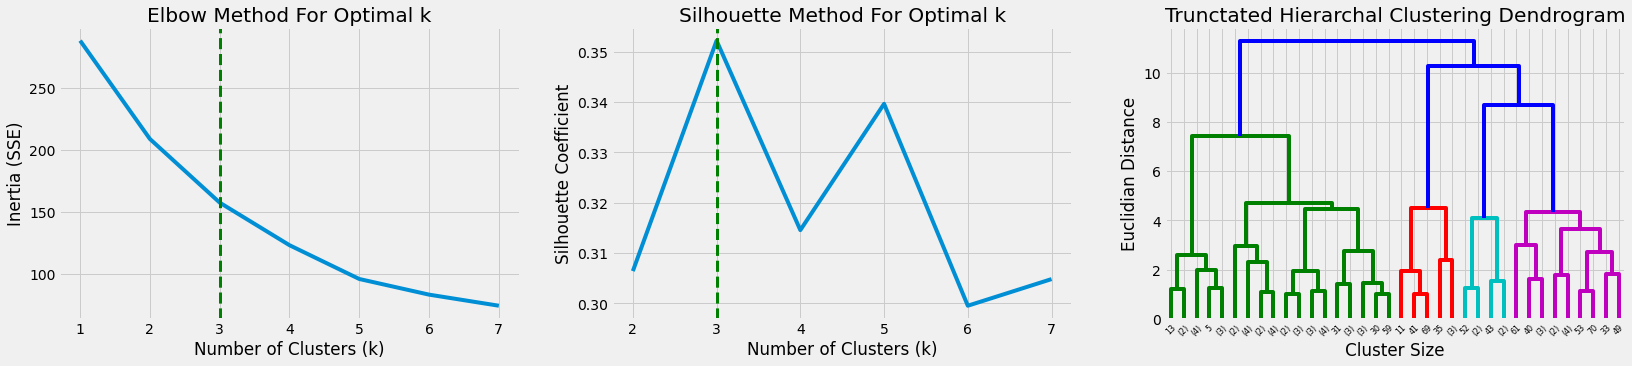

In [23]:
find_k(X_dp, 1, round(len(domestic_df)/10))

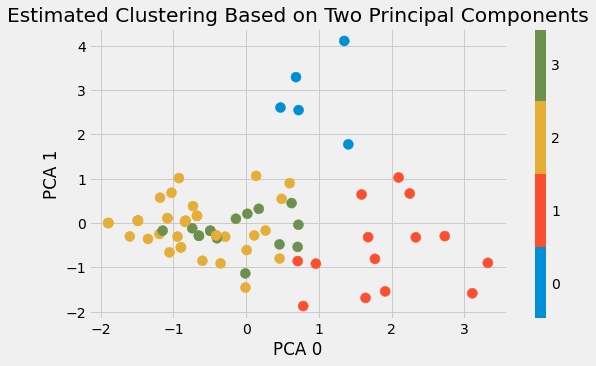

Explained variance ratio (first two components): [0.3825 0.2572]


Cluster 0  Cluster 1  Cluster 2  Cluster 3
0          5         14         38         15

In [24]:
cluster(X_dp,4)

In [25]:
apply_clusters(X_dp, 4, "domestic", domestic_df)

In [26]:
results = domestic_df.groupby(['domestic_cluster']).median()
results

0                 DOMESTIC POLICY:  [Possessing marijuana for personal use should not be a criminal offense]  ...  DOMESTIC POLICY:  [Basic utilities like roads and electricity should be publicly owned]
domestic_cluster                                                                                              ...                                                                                         
0                                                                                                       -1.0  ...                                                                                      2.0
1                                                                                                        3.0  ...                                                                                      0.0
2                                                                                                        3.0  ...                                                                                      2.0
3                                                                                                        3.0  ...                                                                                      3.0

[4 rows x 4 columns]

## Education

In [27]:
ed_filter = [col for col in df if col.startswith('EDUCATION:')]
education_df = df[ed_filter]
X_ed = education_df.values
scaler = StandardScaler()
X_ed = scaler.fit_transform(X_ed)

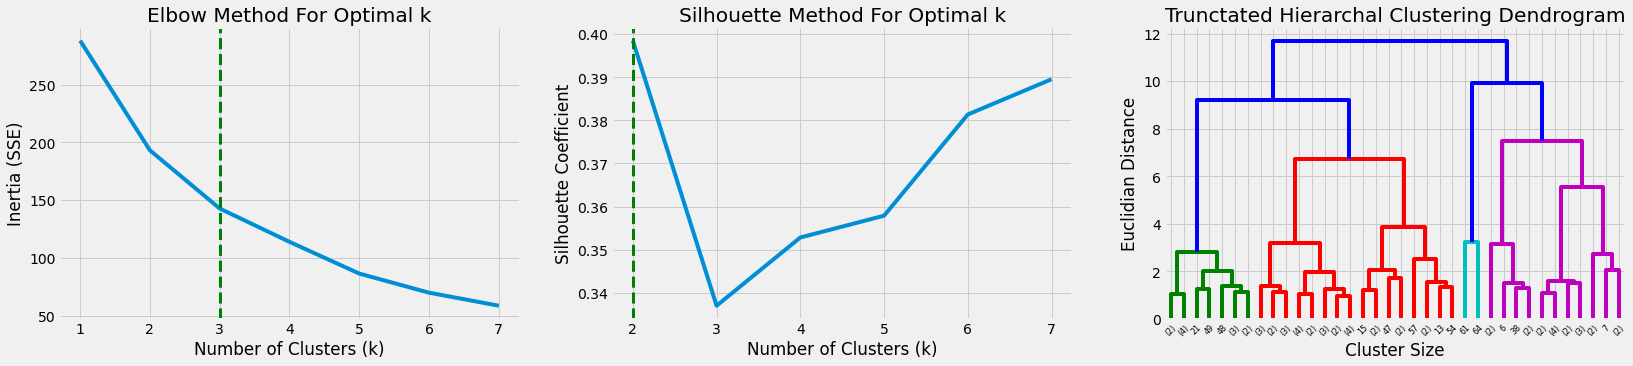

In [28]:
find_k(X_ed, 1, round(len(education_df)/10))

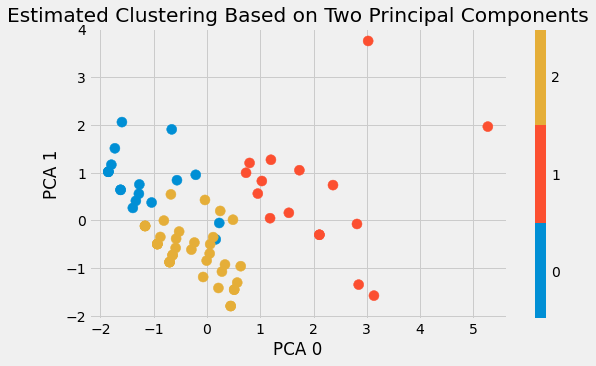

Explained variance ratio (first two components): [0.4798 0.2572]


Cluster 0  Cluster 1  Cluster 2
0         18         16         38

In [29]:
cluster(X_ed, 3)

In [30]:
apply_clusters(X_ed, 3, "education", education_df)

In [31]:
X = education_df.drop(['education_cluster'], axis=1)
y = education_df['education_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['EDUCATION:  [School should equip the future generation to find jobs first and foremost]', 'EDUCATION:  [Education is an individual’s investment in themselves, therefore they should bare the cost, not the taxpayer]']


In [32]:
education_df = education_df[result]

X_ed = education_df.values
scaler = StandardScaler()
X_ed = scaler.fit_transform(X_ed)

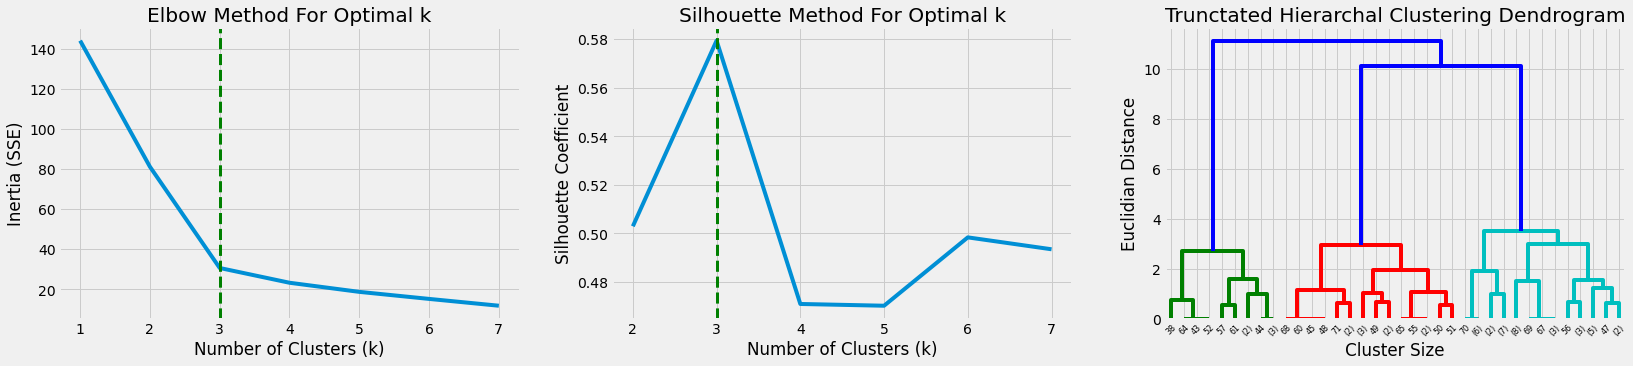

In [33]:
find_k(X_ed, 1, round(len(education_df)/10))

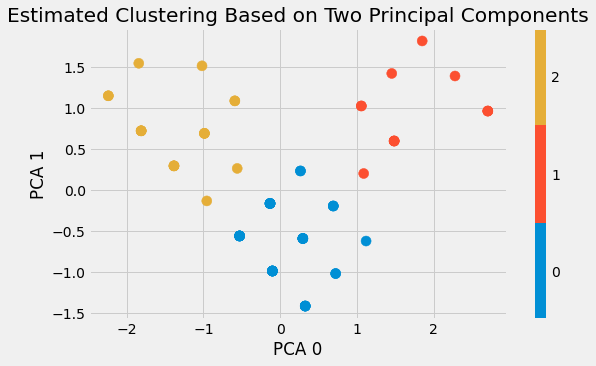

Explained variance ratio (first two components): [0.6393 0.3607]


Cluster 0  Cluster 1  Cluster 2
0         40         13         19

In [34]:
cluster(X_ed,3)

In [35]:
apply_clusters(X_ed, 3, "education", education_df)

In [36]:
results = education_df.groupby(['education_cluster']).median()
results

0                  EDUCATION:  [School should equip the future generation to find jobs first and foremost]  EDUCATION:  [Education is an individual’s investment in themselves, therefore they should bare the cost, not the taxpayer]
education_cluster                                                                                                                                                                                                                     
0                                                                                                      2.0                                                                                                                        -2.5
1                                                                                                      2.0                                                                                                                         1.0
2                                                                                                     -1.0                                                                                                                        -3.0

## The Environment

In [37]:
env_filter = [col for col in df if col.startswith('THE ENVIRONMENT:')]
environment_df = df[env_filter]
X_env = environment_df.values
scaler = StandardScaler()
X_env = scaler.fit_transform(X_env)

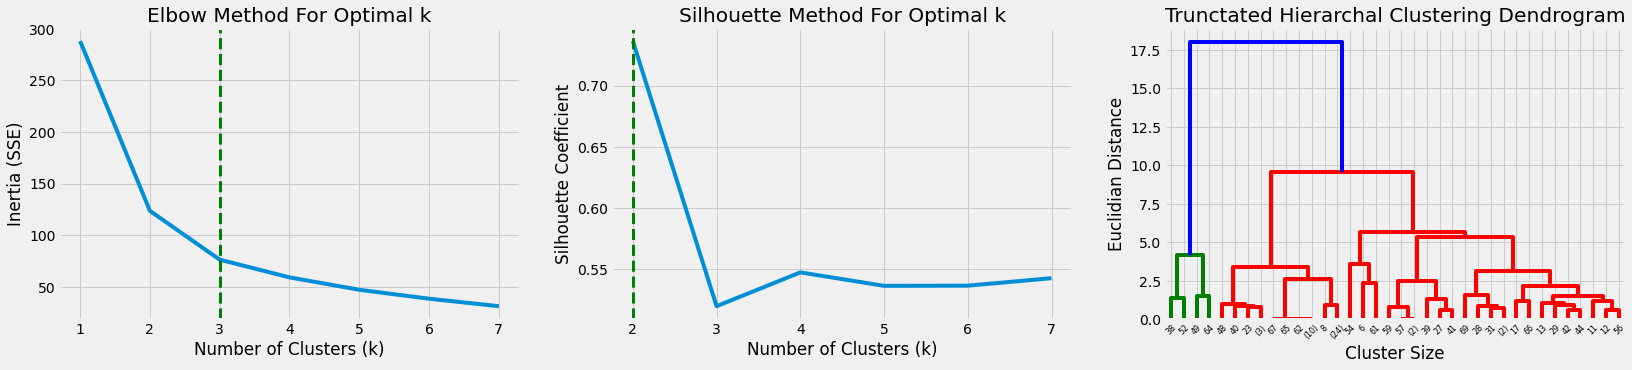

In [38]:
find_k(X_env, 1, round(len(environment_df)/10))

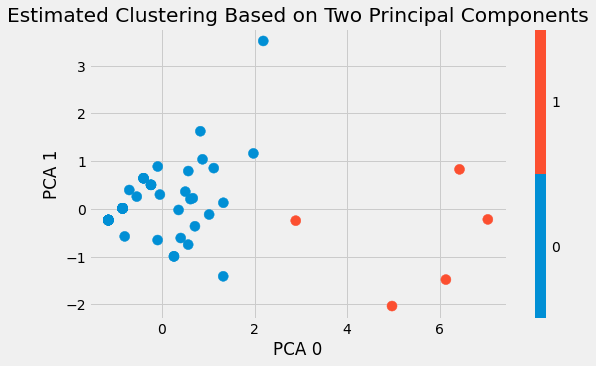

Explained variance ratio (first two components): [0.7778 0.1265]


Cluster 0  Cluster 1
0         67          5

In [39]:
cluster(X_env, 2)

In [40]:
apply_clusters(X_env, 2, "environment", environment_df)

In [41]:
X = environment_df.drop(['environment_cluster'], axis=1)
y = environment_df['environment_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['THE ENVIRONMENT:  [It is important that we work as a united world to combat climate change]']


In [42]:
environment_df = environment_df[result]

X_env = environment_df.values
scaler = StandardScaler()
X_env = scaler.fit_transform(X_env)

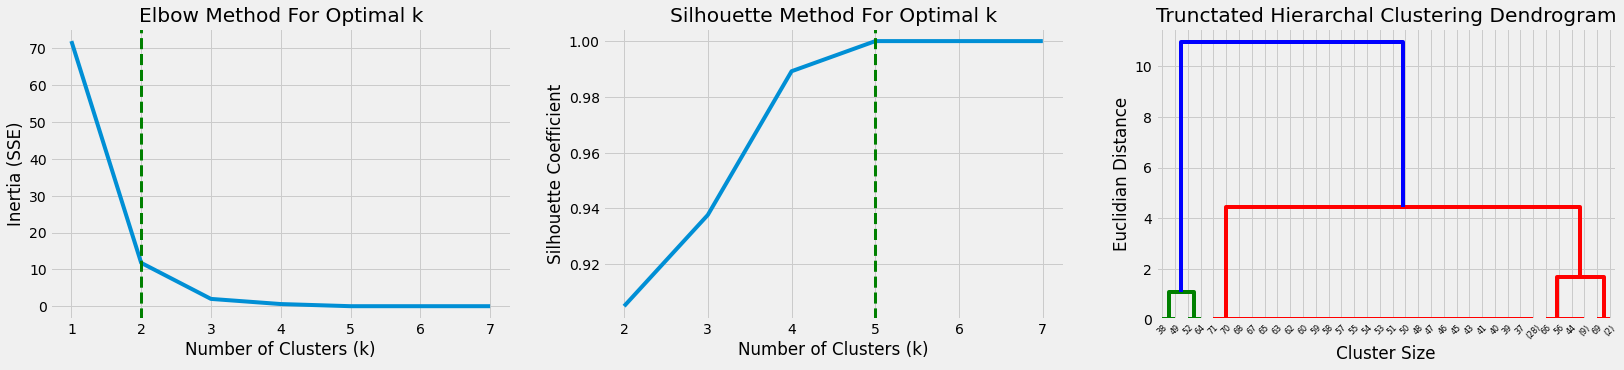

In [43]:
find_k(X_env, 1, round(len(environment_df)/10))

In [44]:
apply_clusters(X_env, 2, "environment", environment_df)

In [45]:
results = environment_df.groupby(['environment_cluster']).median()
results

0                    THE ENVIRONMENT:  [It is important that we work as a united world to combat climate change]
environment_cluster                                                                                             
0                                                                                                            3.0
1                                                                                                           -2.5

## The Future

In [46]:
f_filter = [col for col in df if col.startswith('THE FUTURE:')]
future_df = df[f_filter]
X_f = future_df.values
scaler = StandardScaler()
X_f = scaler.fit_transform(X_f)

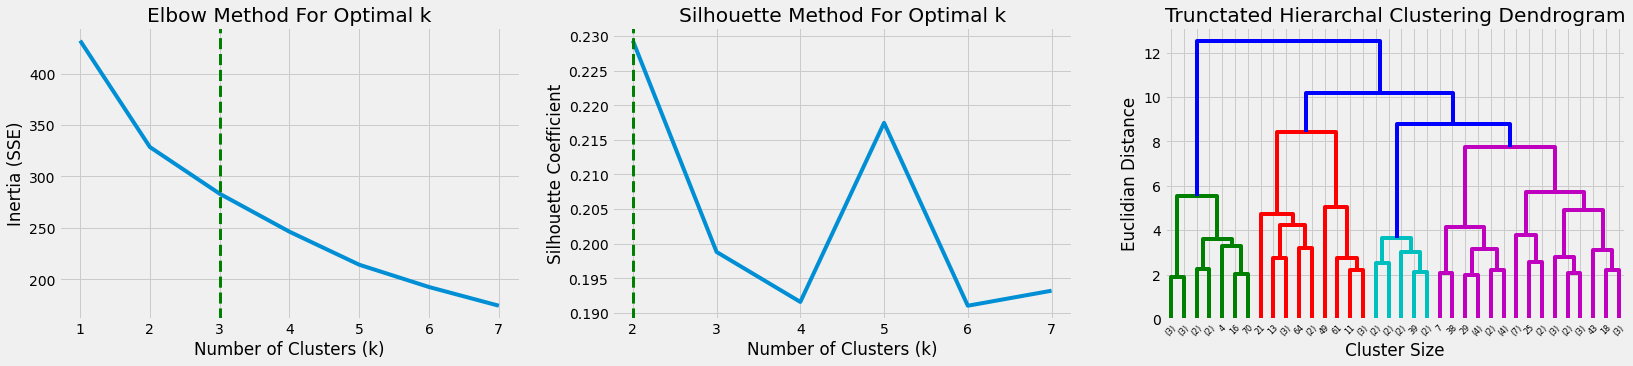

In [47]:
find_k(X_f, 1, round(len(future_df)/10))

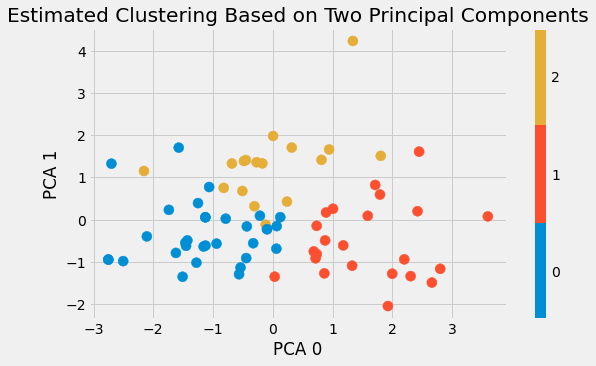

Explained variance ratio (first two components): [0.3478 0.199 ]


Cluster 0  Cluster 1  Cluster 2
0         32         23         17

In [48]:
cluster(X_f, 3)

In [49]:
apply_clusters(X_f, 3, "future", future_df)

In [50]:
X = future_df.drop(['future_cluster'], axis=1)
y = future_df['future_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['THE FUTURE:  [It is important that we think in the long term, beyond our life spans]', 'THE FUTURE:  [It is important that we maintain the traditions of our past]']


In [51]:
future_df = future_df[result]

X_f = future_df.values
scaler = StandardScaler()
X_f = scaler.fit_transform(X_f)

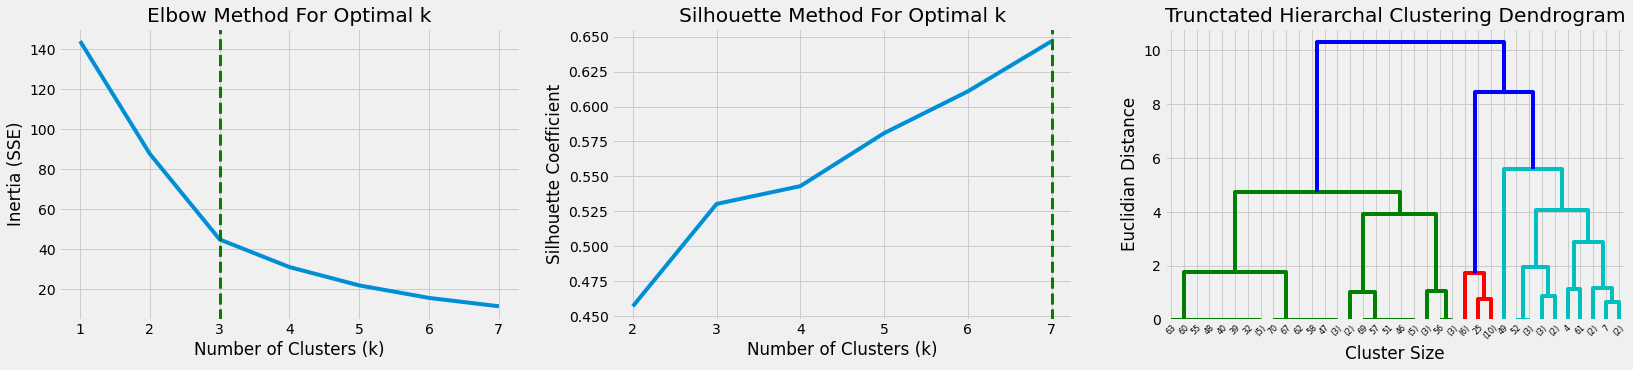

In [52]:
find_k(X_f, 1, round(len(future_df)/10))

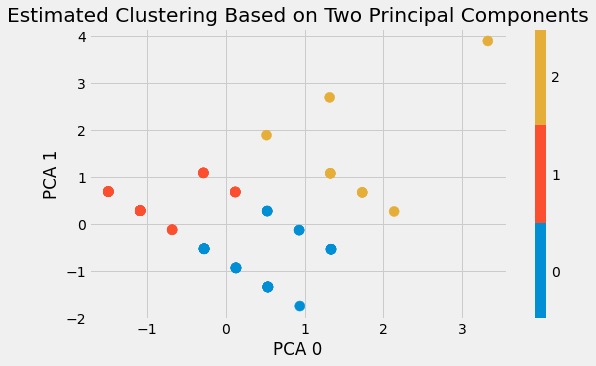

Explained variance ratio (first two components): [0.518 0.482]


Cluster 0  Cluster 1  Cluster 2
0         35         29          8

In [53]:
cluster(X_f,3)

In [54]:
apply_clusters(X_f, 3, "future", future_df)

In [55]:
results = future_df.groupby(['future_cluster']).median()
results

0               THE FUTURE:  [It is important that we think in the long term, beyond our life spans]  THE FUTURE:  [It is important that we maintain the traditions of our past]
future_cluster                                                                                                                                                                  
0                                                                                                3.0                                                                         1.0
1                                                                                                3.0                                                                        -2.0
2                                                                                                1.0                                                                         0.0

## Foreign Policy

In [56]:
fp_filter = [col for col in df if col.startswith('FOREIGN POLICY:')]
foreign_df = df[fp_filter]
X_fp = foreign_df.values
scaler = StandardScaler()
X_fp = scaler.fit_transform(X_fp)

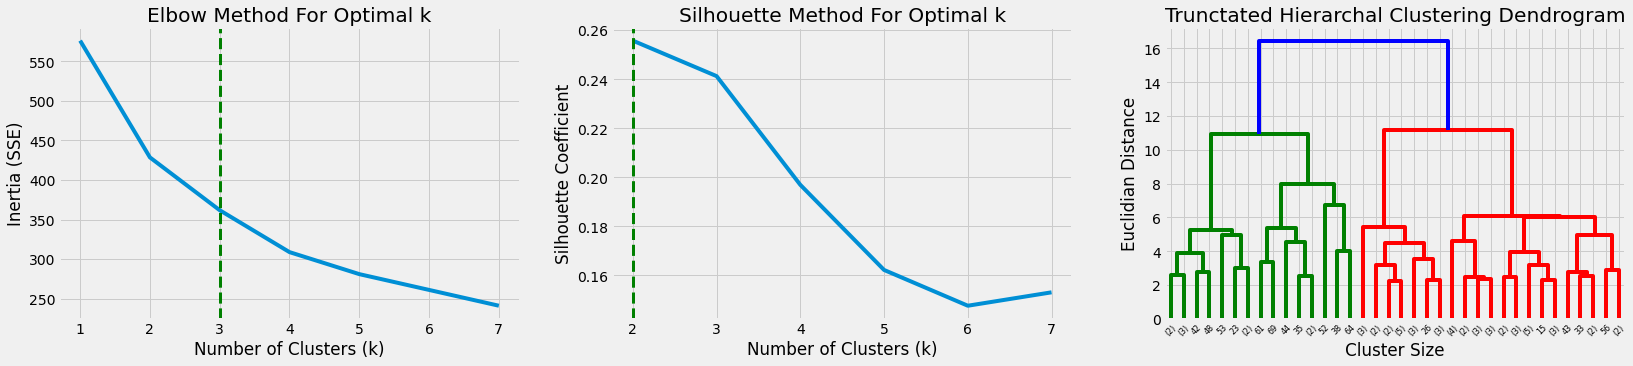

In [57]:
find_k(X_fp, 1, round(len(foreign_df)/10))

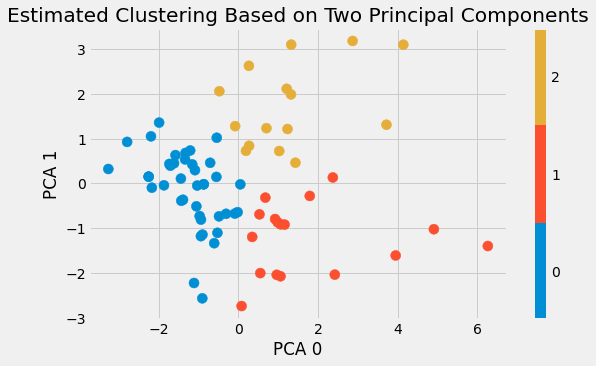

Explained variance ratio (first two components): [0.4038 0.209 ]


Cluster 0  Cluster 1  Cluster 2
0         40         17         15

In [58]:
cluster(X_fp, 3)

In [59]:
apply_clusters(X_fp, 3, "foreign", foreign_df)

In [60]:
X = foreign_df.drop(['foreign_cluster'], axis=1)
y = foreign_df['foreign_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['FOREIGN POLICY:  [In foreign policy, our country should take into account the interests of its allies even if it means making compromises with them]', 'FOREIGN POLICY:  [Its best for the future of our country to be active in world affairs]']


In [61]:
foreign_df = foreign_df[result]

X_fp = foreign_df.values
scaler = StandardScaler()
X_fp = scaler.fit_transform(X_fp)

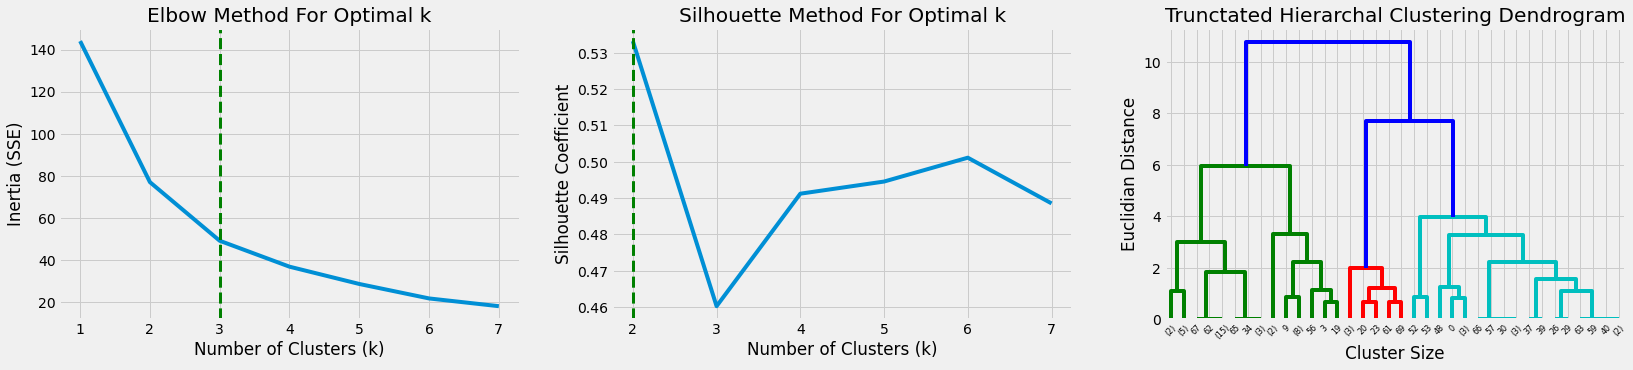

In [62]:
find_k(X_fp, 1, round(len(foreign_df)/10))

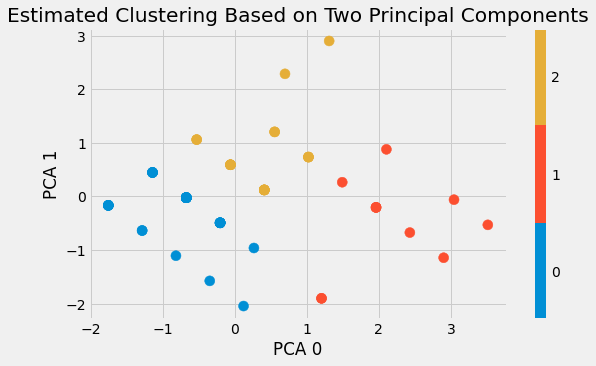

Explained variance ratio (first two components): [0.6862 0.3138]


Cluster 0  Cluster 1  Cluster 2
0         41         11         20

In [63]:
cluster(X_fp, 3)

In [64]:
apply_clusters(X_fp, 3, "foreign", foreign_df)

In [65]:
results = foreign_df.groupby(['foreign_cluster']).median()
results

0                FOREIGN POLICY:  [In foreign policy, our country should take into account the interests of its allies even if it means making compromises with them]  FOREIGN POLICY:  [Its best for the future of our country to be active in world affairs]
foreign_cluster                                                                                                                                                                                                                                               
0                                                                                                                                                                 2.0                                                                                      2.0
1                                                                                                                                                                 0.0                                                                                     -2.0
2                                                                                                                                                                 1.0                                                                                      2.0

## Health Care

In [66]:
hc_filter = [col for col in df if col.startswith('HEALTH CARE:')]
health_df = df[hc_filter]
X_hc = health_df.values
scaler = StandardScaler()
X_hc = scaler.fit_transform(X_hc)

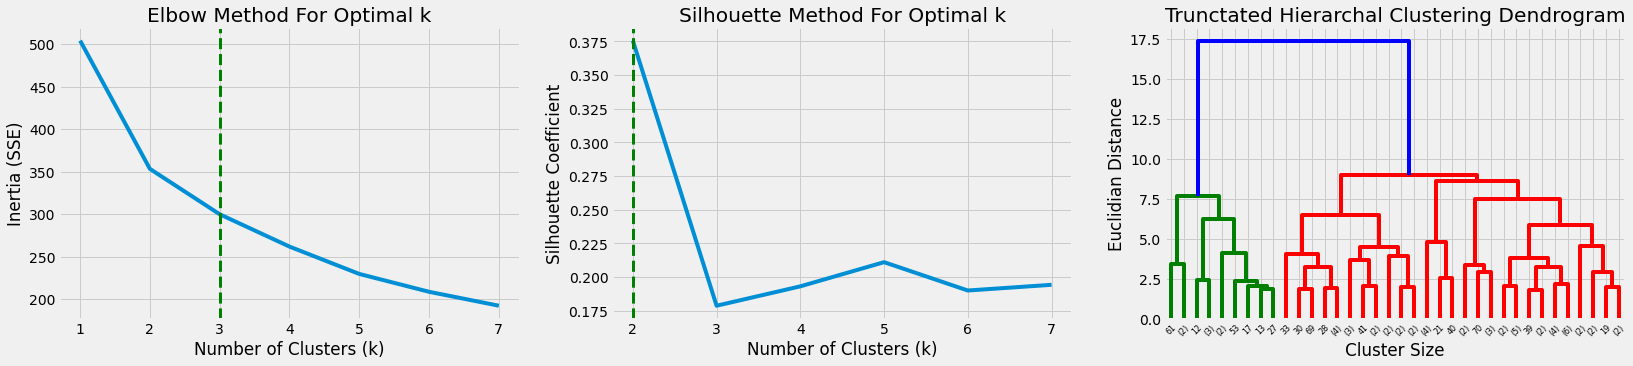

In [67]:
find_k(X_hc,1,round(len(health_df)/10))

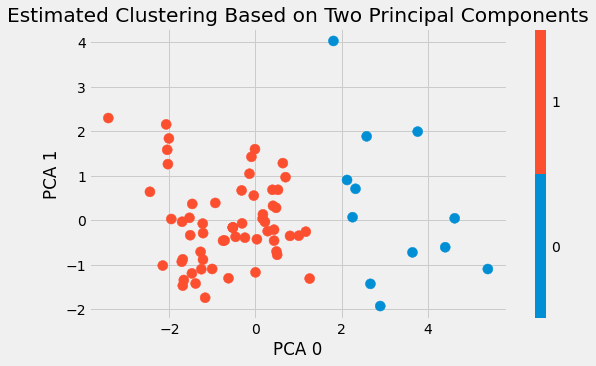

Explained variance ratio (first two components): [0.45   0.1697]


Cluster 0  Cluster 1
0         12         60

In [68]:
cluster(X_hc, 2)

In [69]:
apply_clusters(X_hc, 2, "health", health_df)

In [70]:
X = health_df.drop(['health_cluster'], axis=1)
y = health_df['health_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['HEALTH CARE:  [Publicly-funded research is more beneficial to the people than leaving it to the market]', 'HEALTH CARE:  [The only thing stopping all people from having access to medical care is greed and corruption]', 'HEALTH CARE:  [I support single-payer, universal health care]']


In [71]:
health_df = health_df[result]

X_hc = health_df.values
scaler = StandardScaler()
X_hc = scaler.fit_transform(X_hc)

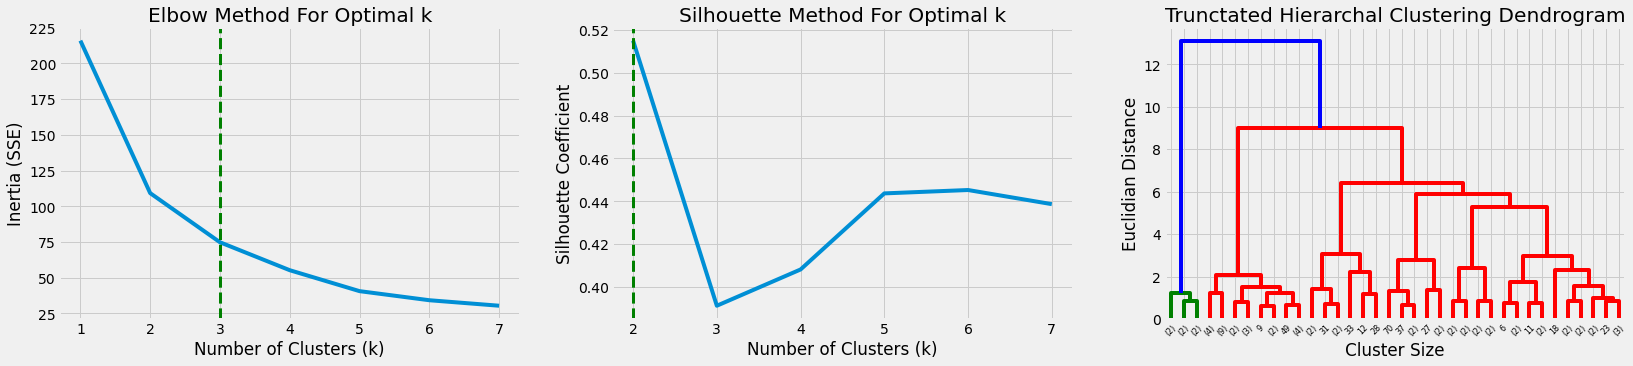

In [72]:
find_k(X_hc,1,round(len(health_df)/10))

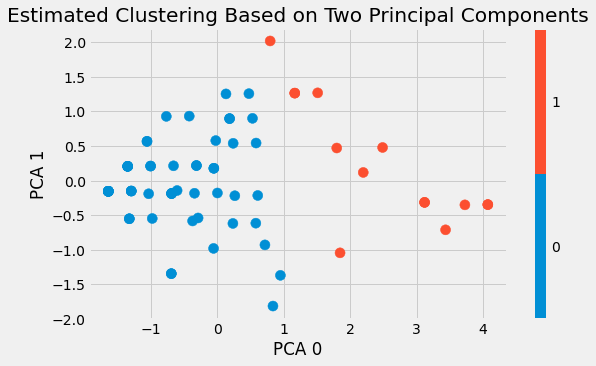

Explained variance ratio (first two components): [0.7255 0.1587]


Cluster 0  Cluster 1
0         58         14

In [73]:
cluster(X_hc, 2)

In [74]:
apply_clusters(X_hc, 2, "health", health_df)

In [75]:
results = health_df.groupby(['health_cluster']).median()
results

0               HEALTH CARE:  [Publicly-funded research is more beneficial to the people than leaving it to the market]  ...  HEALTH CARE:  [I support single-payer, universal health care]
health_cluster                                                                                                           ...                                                               
0                                                                                                                   2.0  ...                                                            2.0
1                                                                                                                  -2.0  ...                                                           -1.0

[2 rows x 3 columns]

## Jobs & the Economy

In [76]:
econ_filter = [col for col in df if col.startswith('JOBS')]
econ_df = df[econ_filter]
X_econ = econ_df.values
scaler = StandardScaler()
X_econ = scaler.fit_transform(X_econ)

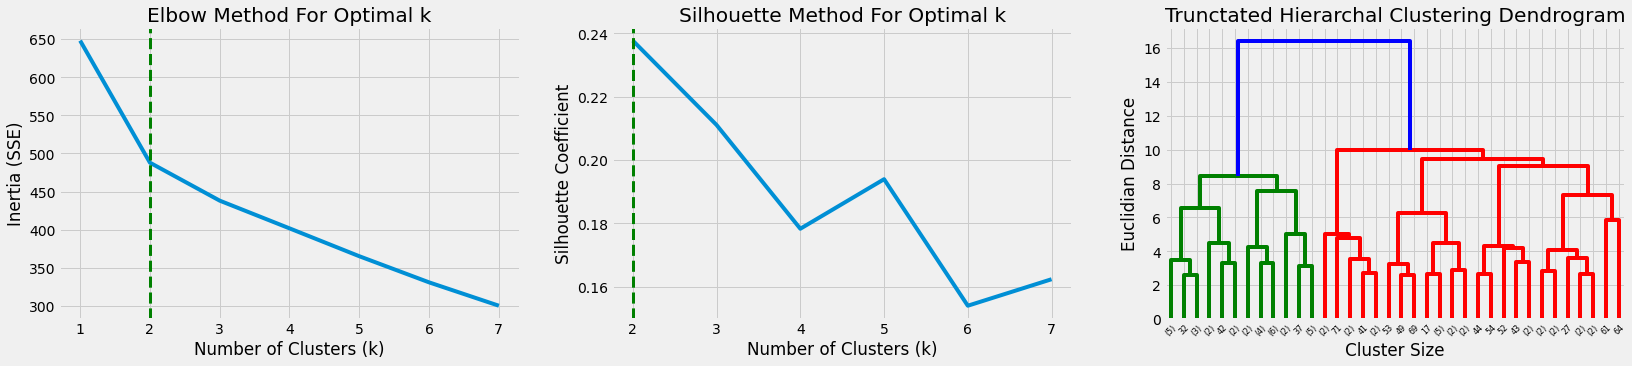

In [77]:
find_k(X_econ,1,round(len(econ_df)/10))

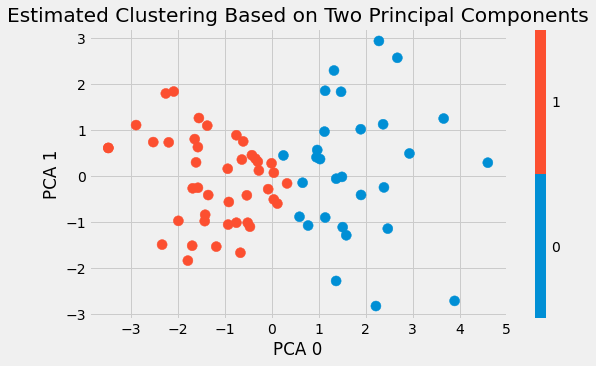

Explained variance ratio (first two components): [0.3438 0.1512]


Cluster 0  Cluster 1
0         29         43

In [78]:
cluster(X_econ, 2)

In [79]:
apply_clusters(X_econ, 2, "econ", econ_df)

In [80]:
X = econ_df.drop(['econ_cluster'], axis=1)
y = econ_df['econ_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['JOBS & THE ECONOMY:  [The economic system in this country is generally fair to most]', 'JOBS & THE ECONOMY:  [Government regulation of business is necessary to protect the public interest]', 'JOBS & THE ECONOMY:  [Those who are able to work, and refuse the opportunity, should not expect society’s support]', 'JOBS & THE ECONOMY:  [The government should do more to help needy citizens, even if it means going deeper into debt]']


In [81]:
econ_df = econ_df[result]

X_econ = econ_df.values
scaler = StandardScaler()
X_econ = scaler.fit_transform(X_econ)

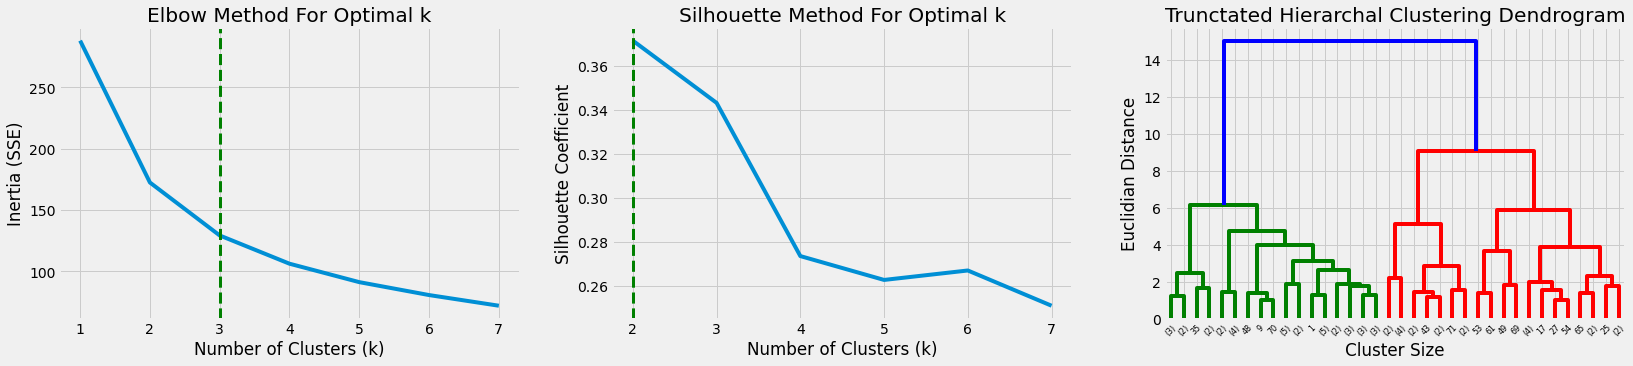

In [82]:
find_k(X_econ,1,round(len(econ_df)/10))

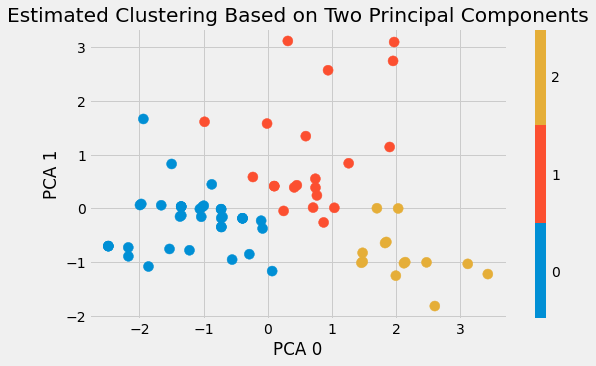

Explained variance ratio (first two components): [0.5469 0.244 ]


Cluster 0  Cluster 1  Cluster 2
0         37         21         14

In [83]:
cluster(X_econ, 3)

In [84]:
apply_clusters(X_econ, 3, "econ", econ_df)

In [85]:
results = econ_df.groupby(['econ_cluster']).median()
results

0             JOBS & THE ECONOMY:  [The economic system in this country is generally fair to most]  ...  JOBS & THE ECONOMY:  [The government should do more to help needy citizens, even if it means going deeper into debt]
econ_cluster                                                                                        ...                                                                                                                      
0                                                                                             -3.0  ...                                                                                                                   2.0
1                                                                                             -1.0  ...                                                                                                                   0.0
2                                                                                              2.0  ...                                                                                                                  -1.5

[3 rows x 4 columns]

## Immigration

In [86]:
im_filter = [col for col in df if col.startswith('IMMIGRATION:')]
im_df = df[im_filter]
X_im = im_df.values
scaler = StandardScaler()
X_im = scaler.fit_transform(X_im)

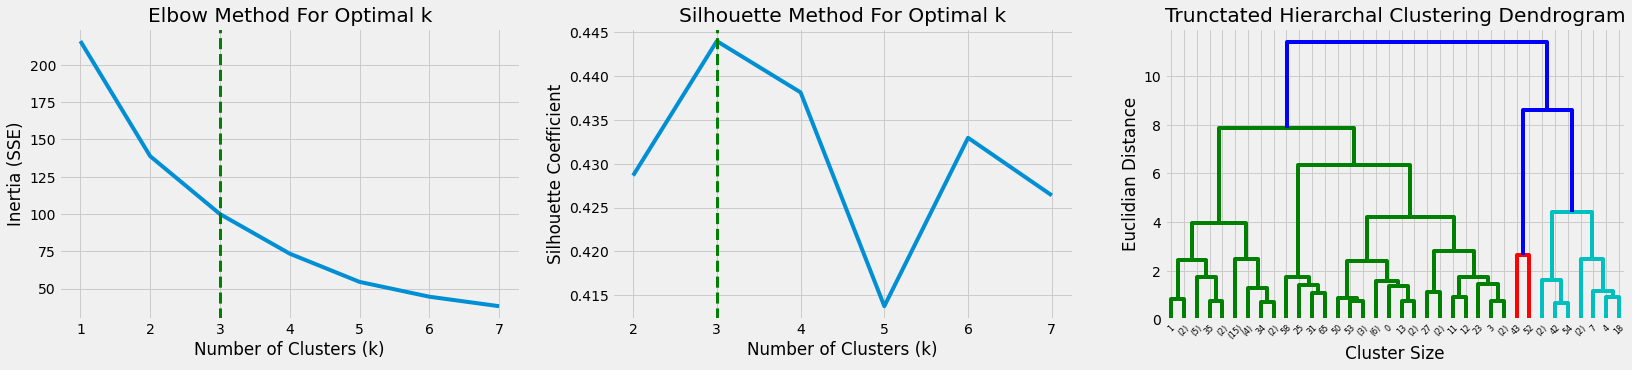

In [87]:
find_k(X_im,1,round(len(im_df)/10))

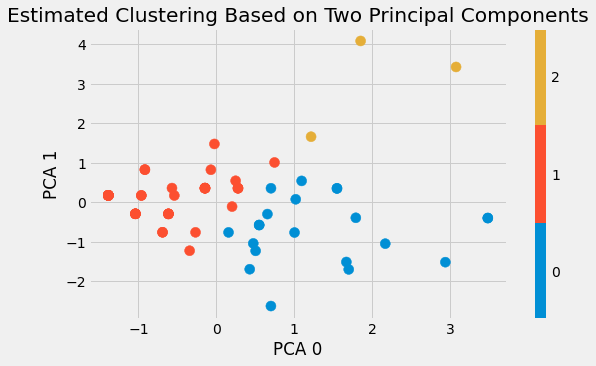

Explained variance ratio (first two components): [0.5257 0.3096]


Cluster 0  Cluster 1  Cluster 2
0         21         48          3

In [88]:
cluster(X_im, 3)

In [89]:
apply_clusters(X_im, 3, "immigration", im_df)

In [90]:
X = im_df.drop(['immigration_cluster'], axis=1)
y = im_df['immigration_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['IMMIGRATION:  [First-generation immigrants can never be fully integrated within their new country]', 'IMMIGRATION:  [Immigrants today strengthen our country because of their hard work and talents]', 'IMMIGRATION:  [All citizens of the world should have a pathway to citizenship in any country]']


In [91]:
im_df = im_df[result]

X_im = im_df.values
scaler = StandardScaler()
X_im = scaler.fit_transform(X_im)

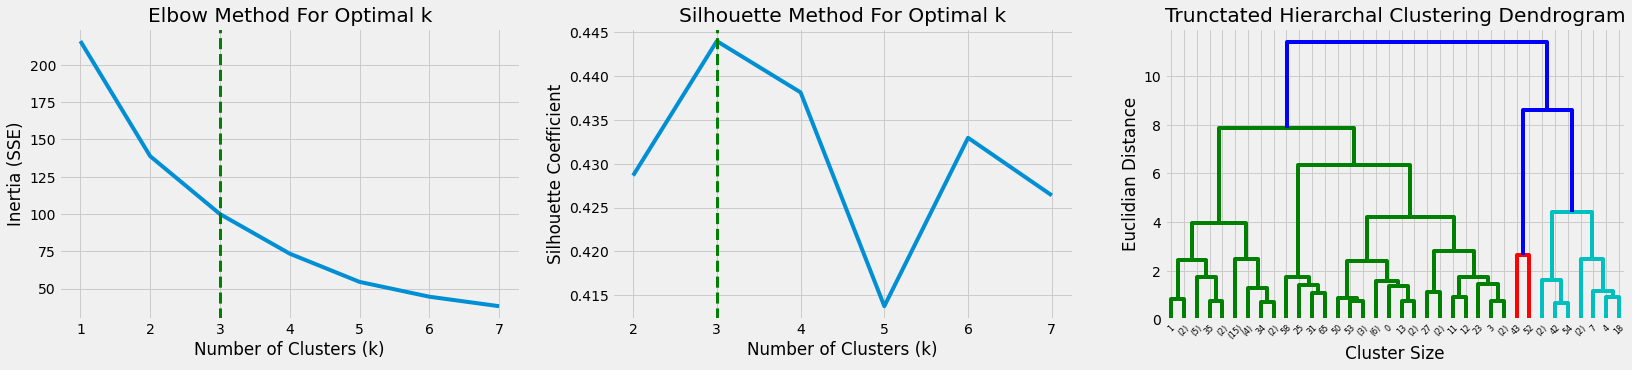

In [92]:
find_k(X_im,1,round(len(im_df)/10))

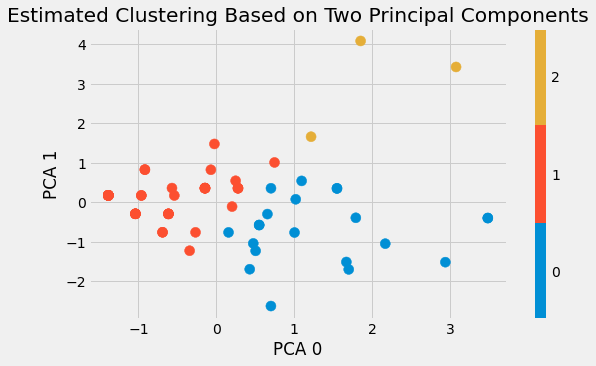

Explained variance ratio (first two components): [0.5257 0.3096]


Cluster 0  Cluster 1  Cluster 2
0         21         48          3

In [93]:
cluster(X_im, 3)

In [94]:
apply_clusters(X_im, 3, "immigration", im_df)

In [95]:
results = im_df.groupby(['immigration_cluster']).median()
results

0                    IMMIGRATION:  [First-generation immigrants can never be fully integrated within their new country]  ...  IMMIGRATION:  [All citizens of the world should have a pathway to citizenship in any country]
immigration_cluster                                                                                                      ...                                                                                               
0                                                                                                                   0.0  ...                                                                                            1.0
1                                                                                                                  -2.0  ...                                                                                            3.0
2                                                                                                                  -3.0  ...                                                                                            1.0

[3 rows x 3 columns]

## Privacy

In [96]:
p_filter = [col for col in df if col.startswith('PRIVACY:')]
privacy_df = df[p_filter]
X_p = privacy_df.values
scaler = StandardScaler()
X_p = scaler.fit_transform(X_p)

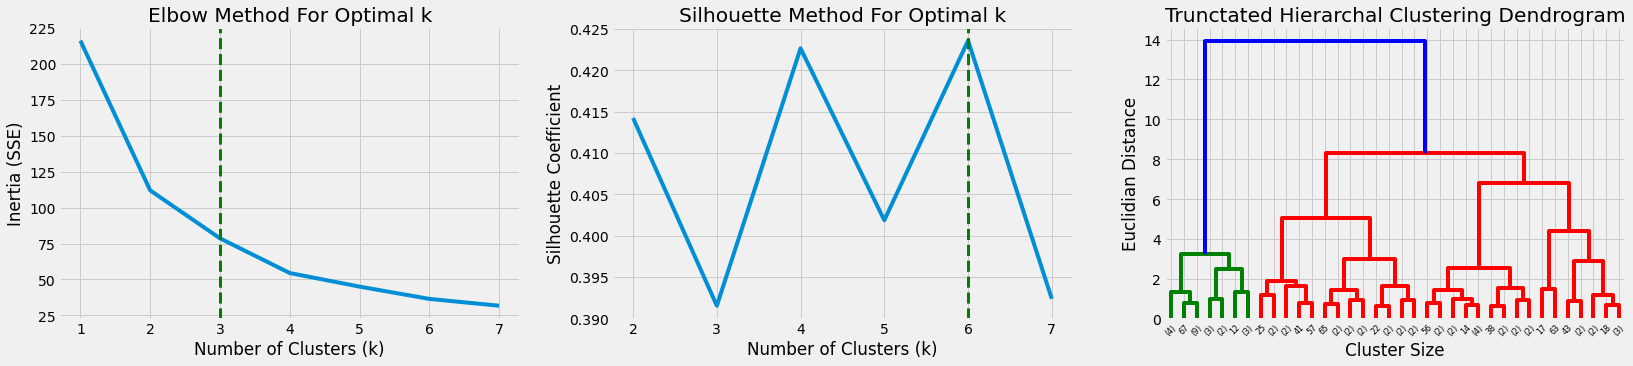

In [97]:
find_k(X_p,1,round(len(privacy_df)/10))

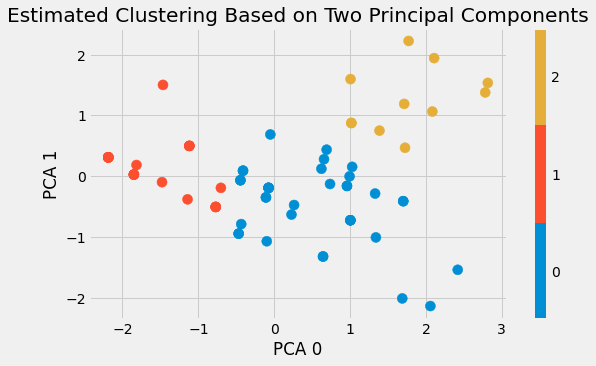

Explained variance ratio (first two components): [0.6647 0.2235]


Cluster 0  Cluster 1  Cluster 2
0         37         24         11

In [98]:
cluster(X_p, 3)

In [99]:
apply_clusters(X_p, 3, "privacy", privacy_df)

In [100]:
X = privacy_df.drop(['privacy_cluster'], axis=1)
y = privacy_df['privacy_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['PRIVACY:  [Although the electronic age makes official surveillance easier, only wrongdoers need to be worried]', 'PRIVACY:  [The sacrifice of some civil liberties is necessary to protect us from acts of terrorism]']


In [101]:
privacy_df = privacy_df[result]

X_p = privacy_df.values
scaler = StandardScaler()
X_p = scaler.fit_transform(X_p)

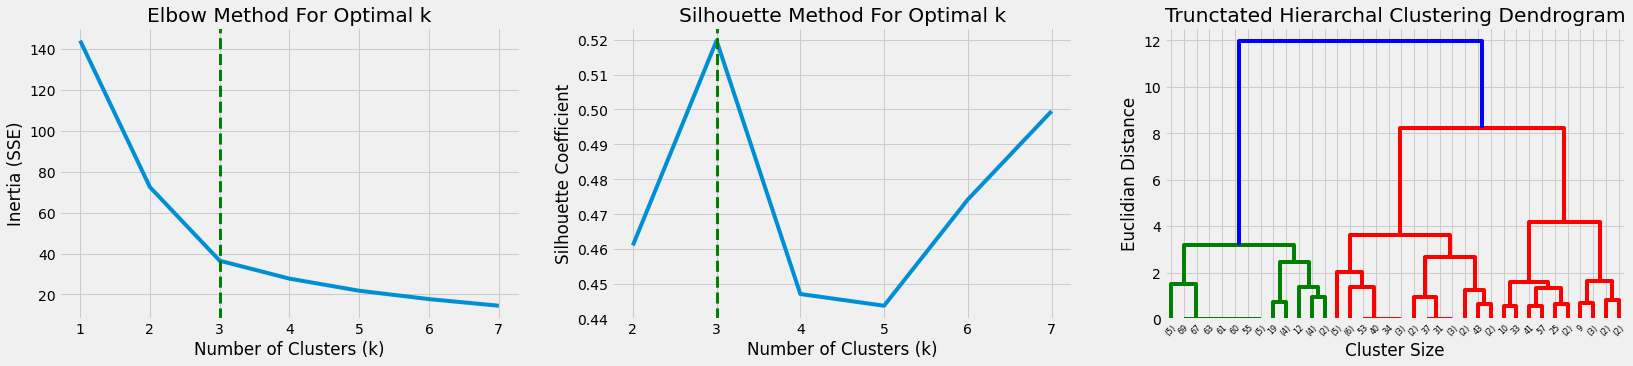

In [102]:
find_k(X_p,1,round(len(privacy_df)/10))

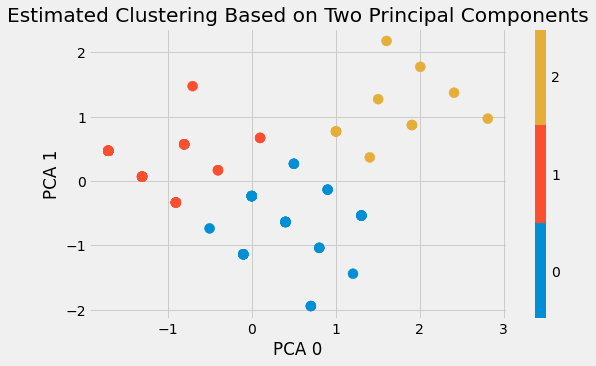

Explained variance ratio (first two components): [0.6791 0.3209]


Cluster 0  Cluster 1  Cluster 2
0         32         29         11

In [103]:
cluster(X_p,3)

In [104]:
apply_clusters(X_p, 3, "privacy", privacy_df)

In [105]:
results = privacy_df.groupby(['privacy_cluster']).median()
results

0                PRIVACY:  [Although the electronic age makes official surveillance easier, only wrongdoers need to be worried]  PRIVACY:  [The sacrifice of some civil liberties is necessary to protect us from acts of terrorism]
privacy_cluster                                                                                                                                                                                                                     
0                                                                                                                          -2.0                                                                                                  1.0
1                                                                                                                          -3.0                                                                                                 -2.0
2                                                                                                                           1.0                                                                                                  0.0

## Race, Gender, and Sexual Orientation

In [106]:
rgs_filter = [col for col in df if col.startswith('RACE')]
rgs_df = df[rgs_filter]
X_rgs = rgs_df.values
scaler = StandardScaler()
X_rgs = scaler.fit_transform(X_rgs)

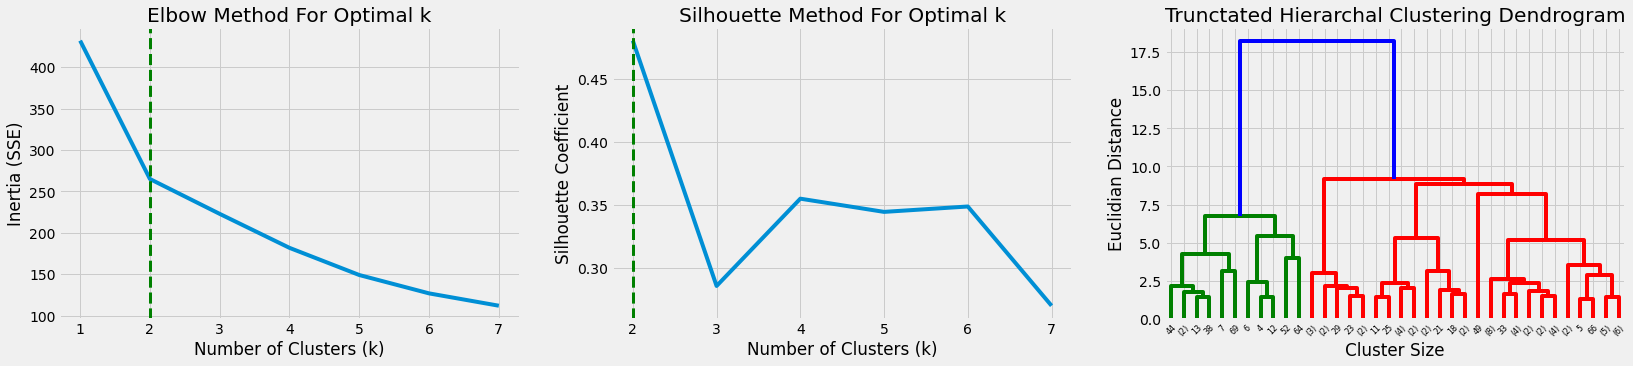

In [107]:
find_k(X_rgs,1,round(len(rgs_df)/10))

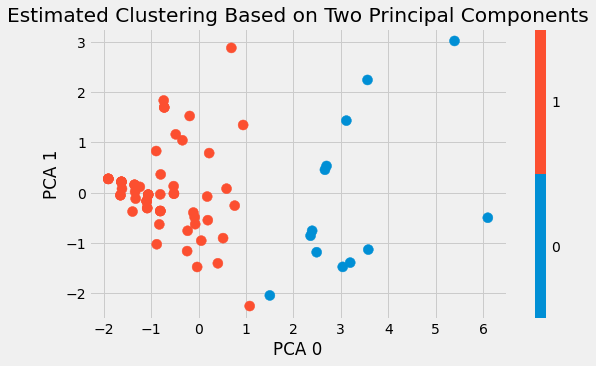

Explained variance ratio (first two components): [0.5103 0.1673]


Cluster 0  Cluster 1
0         13         59

In [108]:
cluster(X_rgs,2)

In [109]:
apply_clusters(X_rgs, 2, "race/gender/sexuality", rgs_df)

In [110]:
X = rgs_df.drop(['race/gender/sexuality_cluster'], axis=1)
y = rgs_df['race/gender/sexuality_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['RACE, GENDER, SEXUAL ORIENTATION:  [Homosexuality should be discouraged by society]', 'RACE, GENDER, SEXUAL ORIENTATION:  [The obstacles that once made it harder for women than men to get ahead are now largely gone]', 'RACE, GENDER, SEXUAL ORIENTATION:  [Discrimination is the main reason why many minorities can’t get ahead these days]']


In [111]:
rgs_df = rgs_df[result]

X_rgs = rgs_df.values
scaler = StandardScaler()
X_rgs = scaler.fit_transform(X_rgs)

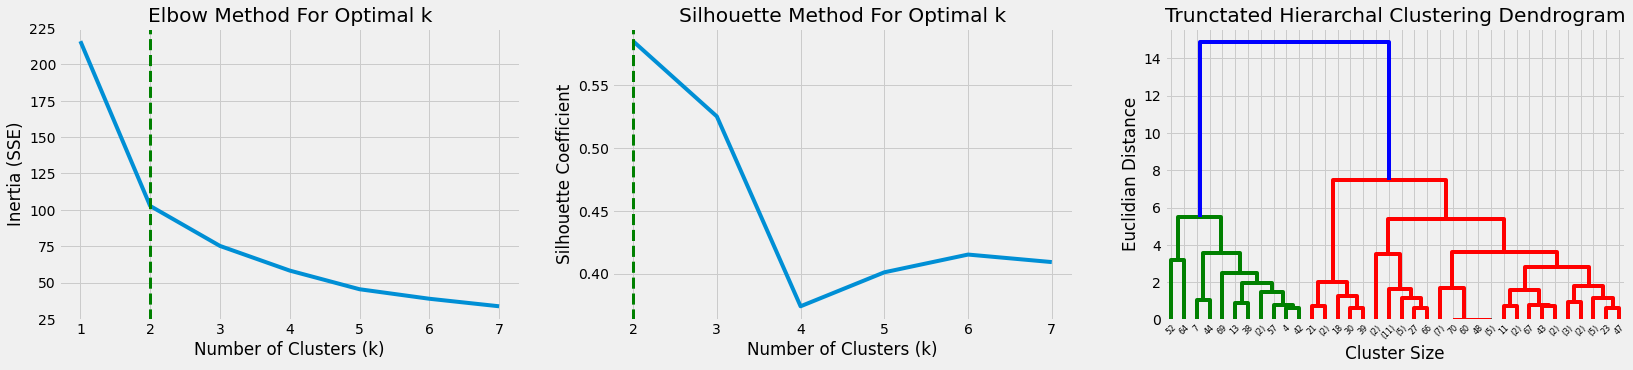

In [112]:
find_k(X_rgs,1,round(len(rgs_df)/10))

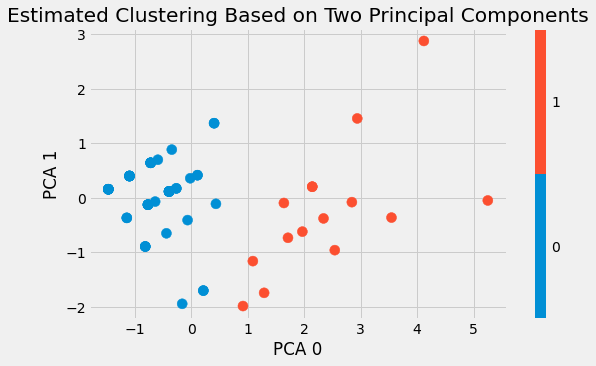

Explained variance ratio (first two components): [0.6815 0.1989]


Cluster 0  Cluster 1
0         57         15

In [113]:
cluster(X_rgs,2)

In [114]:
apply_clusters(X_rgs, 2, "race/gender/sexuality", rgs_df)

In [115]:
results = rgs_df.groupby(['race/gender/sexuality_cluster']).median()
results

0                              RACE, GENDER, SEXUAL ORIENTATION:  [Homosexuality should be discouraged by society]  ...  RACE, GENDER, SEXUAL ORIENTATION:  [Discrimination is the main reason why many minorities can’t get ahead these days]
race/gender/sexuality_cluster                                                                                       ...                                                                                                                       
0                                                                                                             -3.0  ...                                                                                                                    2.0
1                                                                                                             -1.0  ...                                                                                                                   -1.0

[2 rows x 3 columns]

## Religion

In [116]:
rel_filter = [col for col in df if col.startswith('RELIGION:')]
rel_df = df[rel_filter]
X_rel = rel_df.values
scaler = StandardScaler()
X_rel = scaler.fit_transform(X_rel)

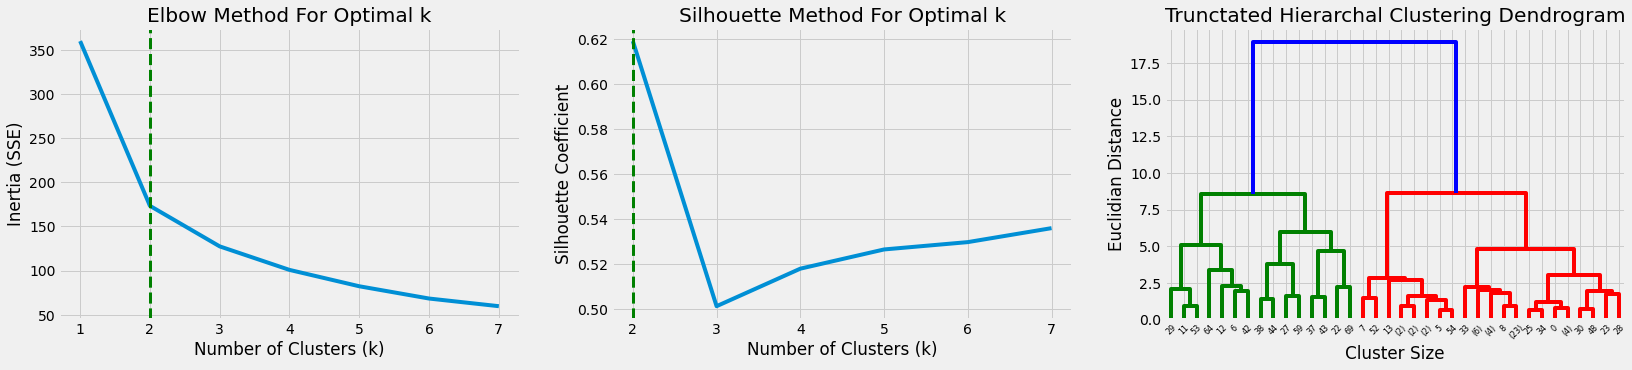

In [117]:
find_k(X_rel,1,round(len(rel_df)/10))

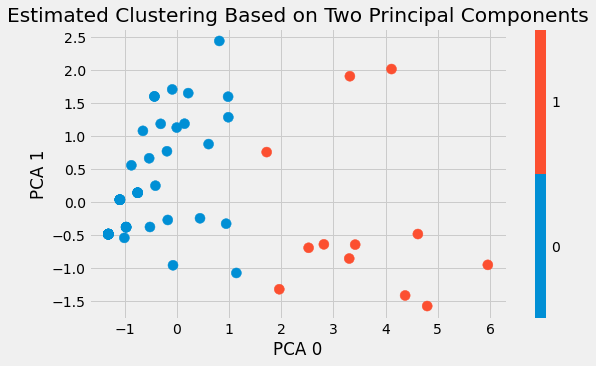

Explained variance ratio (first two components): [0.645  0.1526]


Cluster 0  Cluster 1
0         60         12

In [118]:
cluster(X_rel,2)

In [119]:
apply_clusters(X_rel, 2, "religious", rel_df)

In [120]:
X = rel_df.drop(['religious_cluster'], axis=1)
y = rel_df['religious_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['RELIGION:  [My religious values should be spread as much as possible]', 'RELIGION:  [You cannot be moral without being religious]', 'RELIGION:  [It is important that my child’s school instills religious values]']


In [121]:
rel_df = rel_df[result]

X_rel = rel_df.values
scaler = StandardScaler()
X_rel = scaler.fit_transform(X_rel)

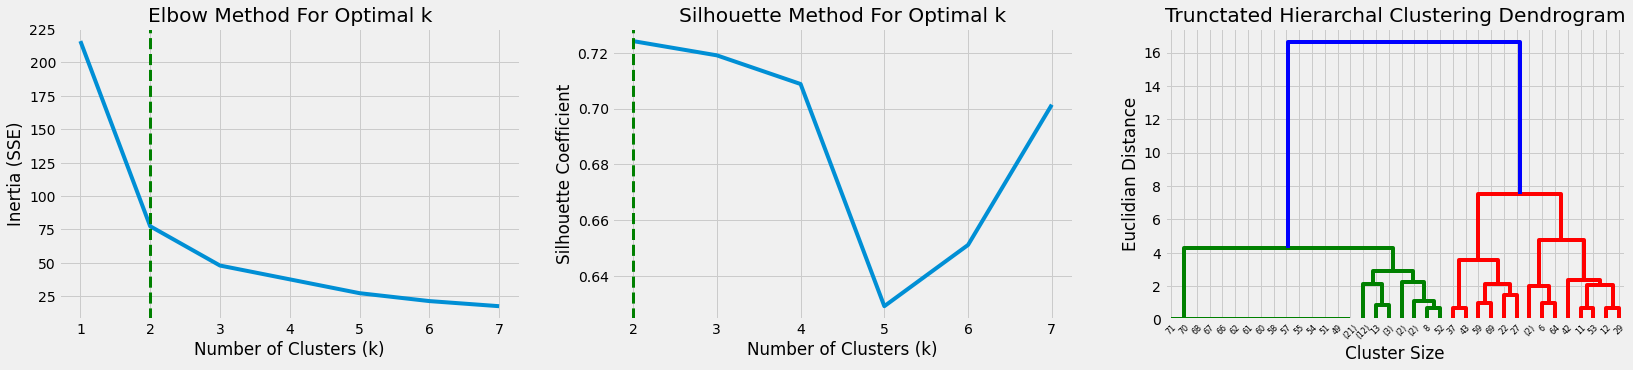

In [122]:
find_k(X_rel,1,round(len(rel_df)/10))

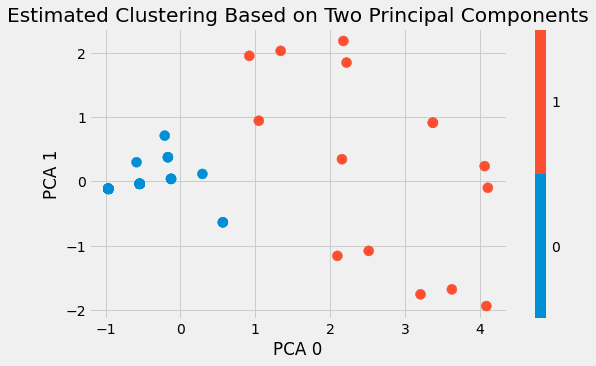

Explained variance ratio (first two components): [0.7519 0.1547]


Cluster 0  Cluster 1
0         57         15

In [123]:
cluster(X_rel,2)

In [124]:
apply_clusters(X_rel, 2, "religious", rel_df)

In [125]:
results = rel_df.groupby(['religious_cluster']).median()
results

0                  RELIGION:  [My religious values should be spread as much as possible]  ...  RELIGION:  [It is important that my child’s school instills religious values]
religious_cluster                                                                         ...                                                                               
0                                                                                   -3.0  ...                                                                           -3.0
1                                                                                    0.0  ...                                                                            1.0

[2 rows x 3 columns]

#**Decision-Making Dimensions**

## Creating Dimension DataFrames

In [126]:
#institutionalist vs anarchist
ia_df = df.iloc[:,[0,1,3,4,5,6,8,9,12,13,16,17,18,19,20,21,23,28,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,47,50,51,52,53,55,56,57,58,59,60,61,62,63]]

#short term vs long term
sl_df = df.iloc[:,[0,2,8,13,14,15,16,17,18,19,20,21,22,25,26,38,41,46,50,54,63]]

#collectivist vs iNdividualist
cn_df = df.iloc[:,[0,2,5,6,7,8,9,10,12,13,14,15,16,18,22,23,24,25,26,27,28,29,30,31,32,33,36,37,38,39,40,41,42,43,44,45,46,48,49,50,51,52,54,55,56,58,60]]

#relativist vs aBsolutist
rb_df = df.iloc[:,[0,1,4,5,7,9,11,13,14,16,17,20,22,24,25,26,27,28,29,30,31,33,34,35,36,37,38,40,41,42,43,45,46,49,50,51,53,54,55,56,57,59,60,61,62,63]]

##Institutionalist vs. Anarchist (I/A)

In [127]:
X_ia = ia_df.values
scaler = StandardScaler()
X_ia = scaler.fit_transform(X_ia)

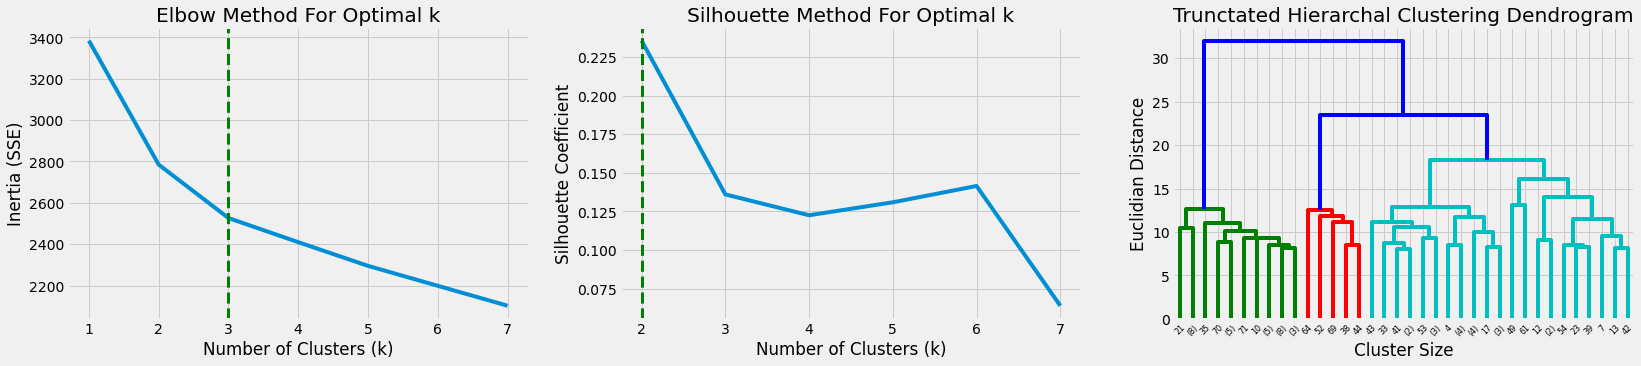

In [128]:
find_k(X_ia,1,round(len(ia_df)/10))

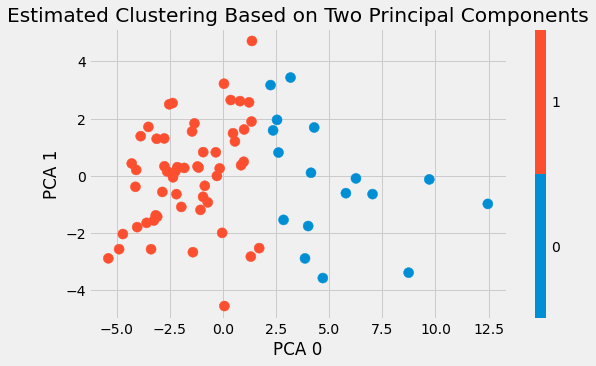

Explained variance ratio (first two components): [0.2689 0.0749]


Cluster 0  Cluster 1
0         17         55

In [129]:
cluster(X_ia, 2)

In [130]:
apply_clusters(X_ia, 2, "institutional", ia_df)

In [131]:
X = ia_df.drop(['institutional_cluster'], axis=1)
y = ia_df['institutional_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['HEALTH CARE:  [I support single-payer, universal health care]', 'RELIGION:  [My religious values should be spread as much as possible]', 'EDUCATION:  [Education is an individual’s investment in themselves, therefore they should bare the cost, not the taxpayer]']


In [132]:
ia_df = ia_df[result]

X_ia = ia_df.values
scaler = StandardScaler()
X_ia = scaler.fit_transform(X_ia)

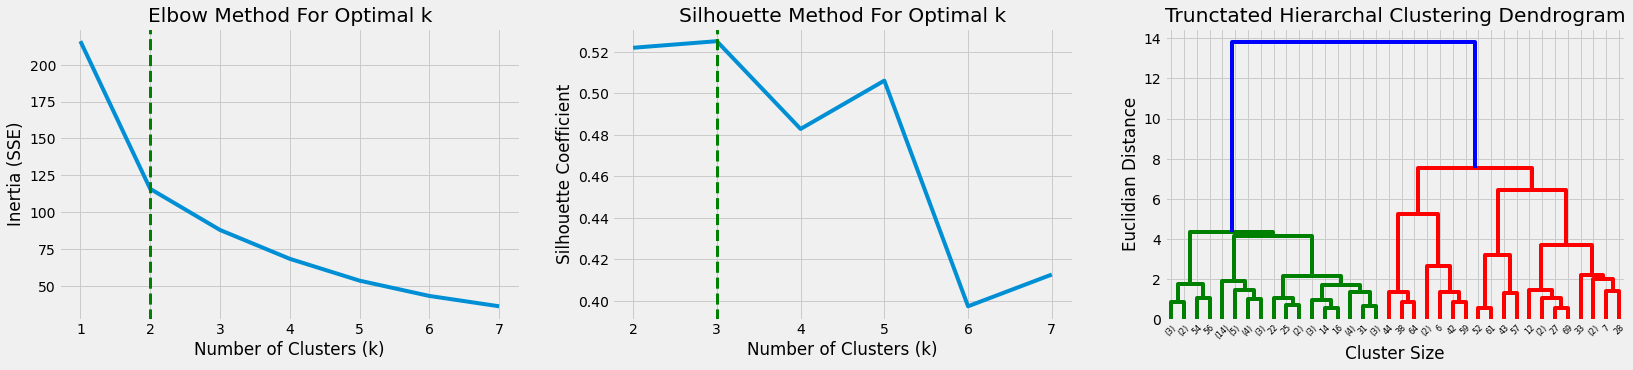

In [133]:
find_k(X_ia,1,round(len(ia_df)/10))

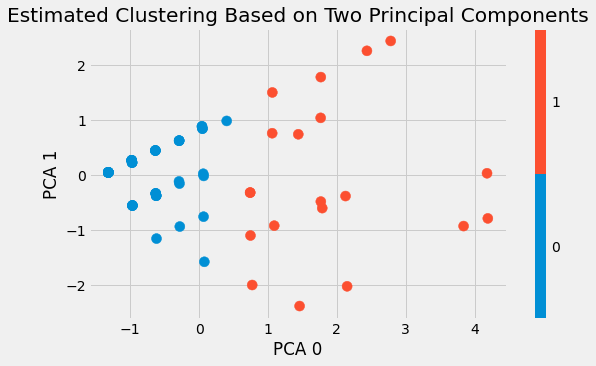

Explained variance ratio (first two components): [0.6289 0.2335]


Cluster 0  Cluster 1
0         52         20

In [134]:
cluster(X_ia, 2)

In [135]:
apply_clusters(X_ia, 2, "institutional", ia_df)

In [136]:
results = ia_df.groupby(['institutional_cluster']).median()
results

0                      HEALTH CARE:  [I support single-payer, universal health care]  ...  EDUCATION:  [Education is an individual’s investment in themselves, therefore they should bare the cost, not the taxpayer]
institutional_cluster                                                                 ...                                                                                                                            
0                                                                                3.0  ...                                                                                                                        -3.0
1                                                                                0.0  ...                                                                                                                         1.0

[2 rows x 3 columns]


MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 95.83%
Validation R-Squared:  0.9583333333333334
Validation Root Mean Square Error: 0.2041241452319315


CLASSIFICATION REPORT AND CONFUSION MATRIX
                  precision    recall  f1-score   support

       Anarchist       0.95      1.00      0.97        18
Institutionalist       1.00      0.83      0.91         6

        accuracy                           0.96        24
       macro avg       0.97      0.92      0.94        24
    weighted avg       0.96      0.96      0.96        24



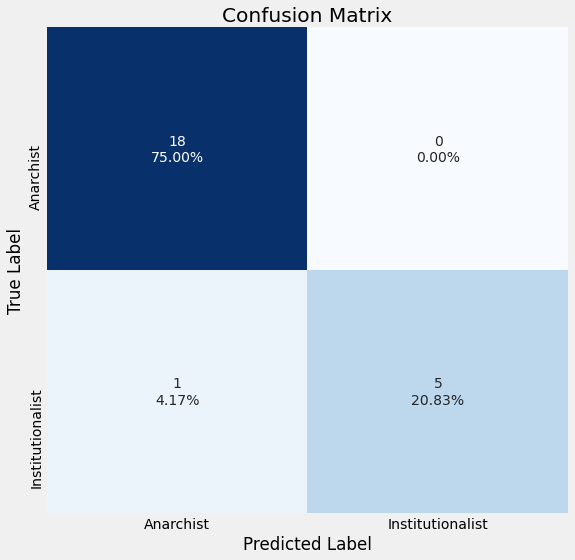

In [137]:
y_ia = ia_df['institutional_cluster']
Xia_train, Xia_test, yia_train, yia_test = train_test_split(X_ia, y_ia, test_size=0.33, random_state=10)

knn_ia = KNeighborsClassifier()
ia_clusters = ['Anarchist','Institutionalist']

run_model(knn_ia,Xia_train,Xia_test,yia_train,yia_test, ia_clusters)

In [138]:
#Parameter tuning with GridSearchCV 

parameters_KNN = {
    'n_neighbors': (1,3,5,7,9),
    'weights': ('uniform', 'distance'),
    'algorithm': ('ball_tree','kd_tree','brute'),
    'leaf_size': (1,5,10,20,30),
    'p': (1,2),
    'metric': ('euclidean','manhattan','chebyshev','minkowski','seuclidean','mahalanobis')}
                   
# with GridSearch
grid_search_KNN = GridSearchCV(
                                estimator=KNeighborsClassifier(),
                                param_grid=parameters_KNN,
                                scoring = 'accuracy',
                                n_jobs = -1,
                                cv = 10
                                )
grid_search_KNN.fit(Xia_train, yia_train)

#Find best parameters
best_parameters = grid_search_KNN.best_params_
print("Grid Search Found the Following Optimal Parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s=%r" % (param_name, best_parameters[param_name]))

Grid Search Found the Following Optimal Parameters: 
algorithm='ball_tree'
leaf_size=5
metric='chebyshev'
n_neighbors=7
p=1
weights='distance'



MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=1,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 95.83%
Validation R-Squared:  0.9583333333333334
Validation Root Mean Square Error: 0.2041241452319315


CLASSIFICATION REPORT AND CONFUSION MATRIX
                  precision    recall  f1-score   support

       Anarchist       0.95      1.00      0.97        18
Institutionalist       1.00      0.83      0.91         6

        accuracy                           0.96        24
       macro avg       0.97      0.92      0.94        24
    weighted avg       0.96      0.96      0.96        24



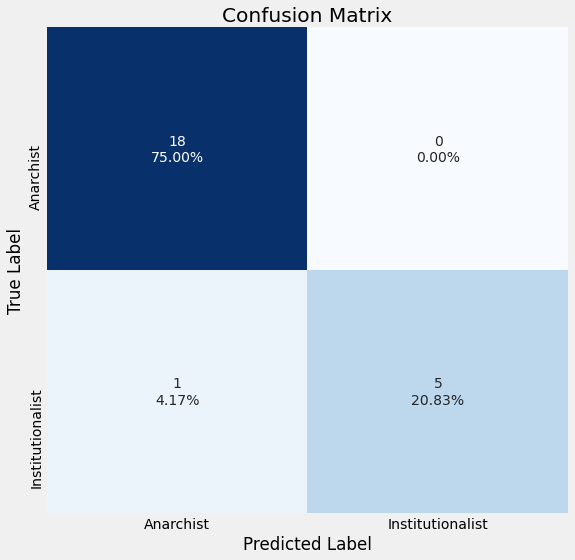

In [139]:
knn_ia = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,metric='euclidean',
                              p=1,weights='uniform')

run_model(knn_ia,Xia_train,Xia_test,yia_train,yia_test, ia_clusters)

## Short Term vs. Long Term Approach to Challenges/Goals (L/S)

In [140]:
X_sl = sl_df.values
scaler = StandardScaler()
X_sl = scaler.fit_transform(X_sl)

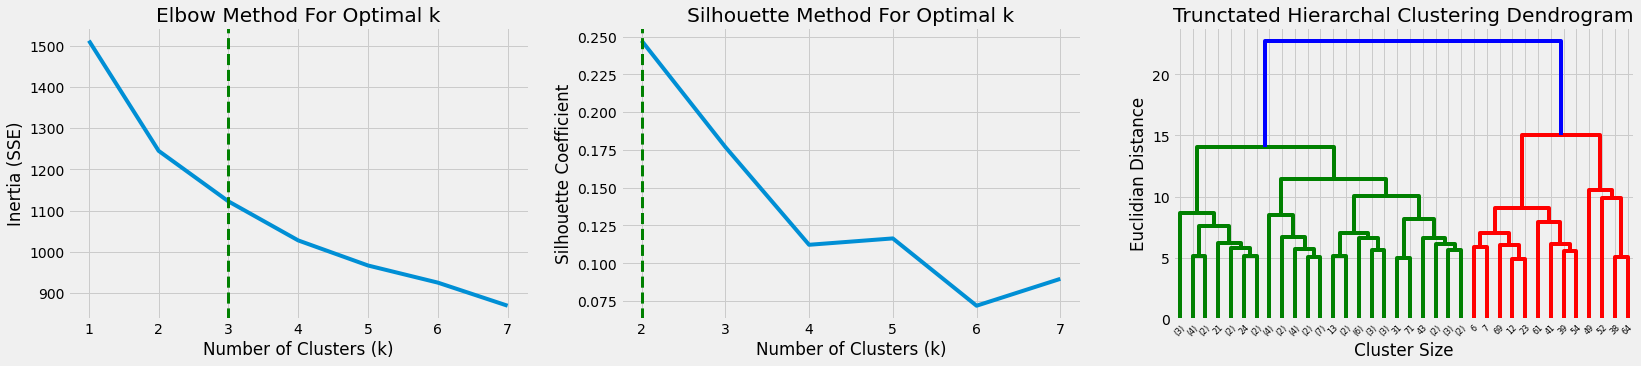

In [141]:
find_k(X_sl,1,round(len(sl_df)/10))

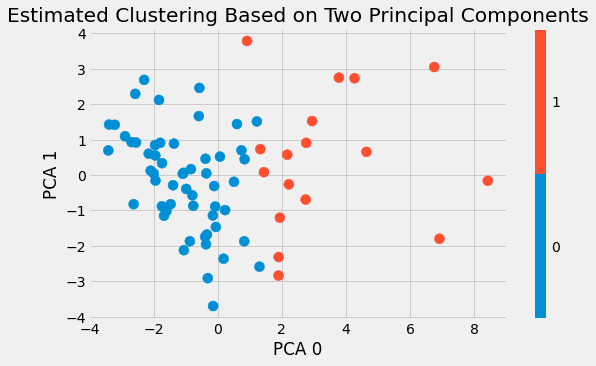

Explained variance ratio (first two components): [0.2678 0.1127]


Cluster 0  Cluster 1
0         55         17

In [142]:
cluster(X_sl, 2)

In [143]:
apply_clusters(X_sl, 2, "time", sl_df)

In [144]:
X = sl_df.drop(['time_cluster'], axis=1)
y = sl_df['time_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['THE ENVIRONMENT:  [Stricter environmental laws and regulations cost too many jobs and hurt the economy]', 'Did you vote in the last national election? We define a national election as any election that ends in the selection of a president or prime minister.', 'THE ENVIRONMENT:  [Climate change is currently one of the greatest threats to our way of life]', 'PRIVACY:  [The sacrifice of some civil liberties is necessary to protect us from acts of terrorism]', 'THE FUTURE:  [It is important that we maintain the traditions of our past]', 'DOMESTIC POLICY:  [Charity is better than social security programs as a means of helping the genuinely disadvantaged]']


In [145]:
sl_df = sl_df[result]

X_sl = sl_df.values
scaler = StandardScaler()
X_sl = scaler.fit_transform(X_sl)

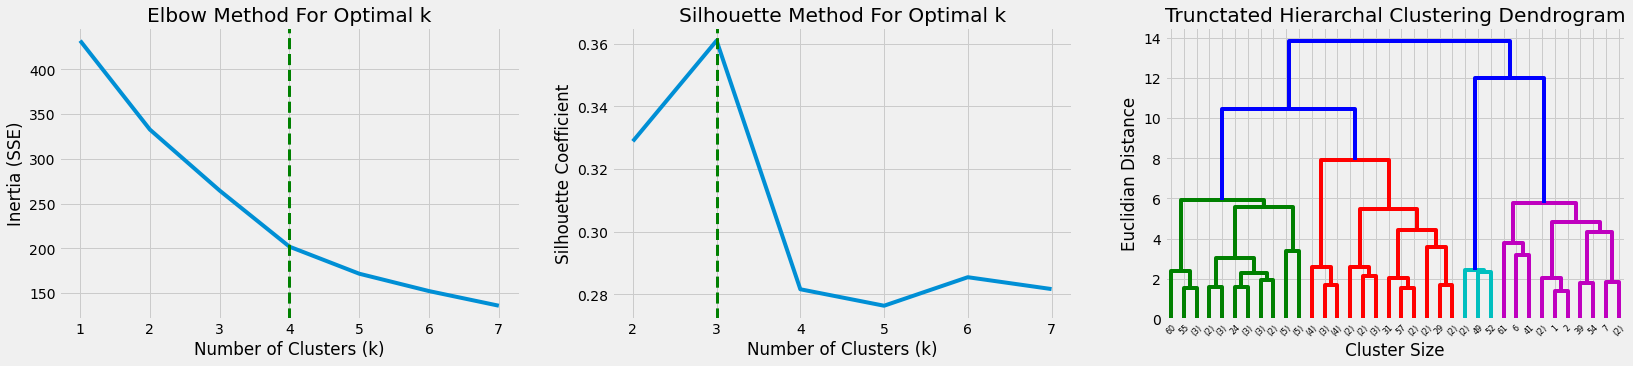

In [146]:
find_k(X_sl,1,round(len(sl_df)/10))

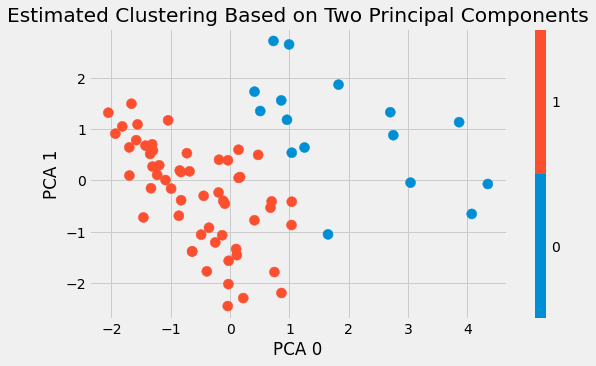

Explained variance ratio (first two components): [0.3264 0.209 ]


Cluster 0  Cluster 1
0         16         56

In [147]:
cluster(X_sl, 2)

In [148]:
apply_clusters(X_sl, 2, "time", sl_df)

In [149]:
results = sl_df.groupby(['time_cluster']).median()
results

0             THE ENVIRONMENT:  [Stricter environmental laws and regulations cost too many jobs and hurt the economy]  ...  DOMESTIC POLICY:  [Charity is better than social security programs as a means of helping the genuinely disadvantaged]
time_cluster                                                                                                           ...                                                                                                                       
0                                                                                                                 0.0  ...                                                                                                                   -2.0
1                                                                                                                -2.5  ...                                                                                                                   -2.0

[2 rows x 6 columns]


MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 93.75%
Training R-Squared:  0.9375
Training Root Mean Square Error 0.25

Validation accuracy: 91.67%
Validation R-Squared:  0.9166666666666666
Validation Root Mean Square Error: 0.28867513459481287


CLASSIFICATION REPORT AND CONFUSION MATRIX
                  precision    recall  f1-score   support

 Long-Term Focus       0.86      0.86      0.86         7
Short-Term Focus       0.94      0.94      0.94        17

        accuracy                           0.92        24
       macro avg       0.90      0.90      0.90        24
    weighted avg       0.92      0.92      0.92        24



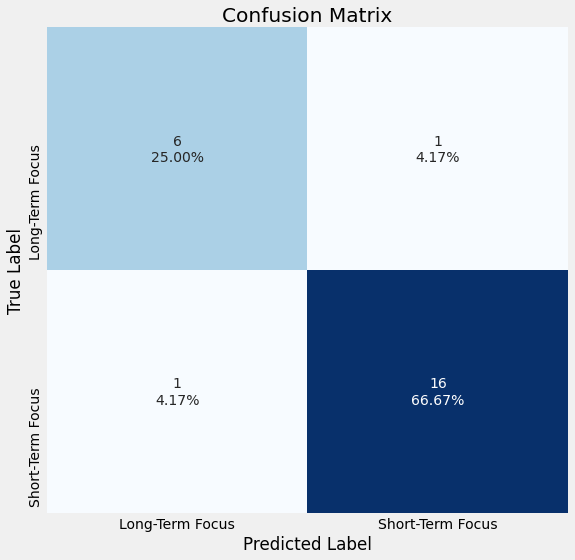

In [150]:
y_sl = sl_df['time_cluster']
Xsl_train, Xsl_test, ysl_train, ysl_test = train_test_split(X_sl, y_sl, test_size=0.33, random_state=10)

knn_sl = KNeighborsClassifier()
sl_clusters = ['Long-Term Focus','Short-Term Focus']

run_model(knn_sl,Xsl_train,Xsl_test,ysl_train,ysl_test, sl_clusters)

In [151]:
#Parameter tuning with GridSearchCV 
grid_search_KNN.fit(Xsl_train, ysl_train)

#Find best parameters
best_parameters = grid_search_KNN.best_params_
print("Grid Search Found the Following Optimal Parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s=%r" % (param_name, best_parameters[param_name]))

Grid Search Found the Following Optimal Parameters: 
algorithm='brute'
leaf_size=1
metric='seuclidean'
n_neighbors=1
p=1
weights='uniform'



MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 91.67%
Validation R-Squared:  0.9166666666666666
Validation Root Mean Square Error: 0.28867513459481287


CLASSIFICATION REPORT AND CONFUSION MATRIX
                  precision    recall  f1-score   support

 Long-Term Focus       0.86      0.86      0.86         7
Short-Term Focus       0.94      0.94      0.94        17

        accuracy                           0.92        24
       macro avg       0.90      0.90      0.90        24
    weighted avg       0.92      0.92      0.92        24



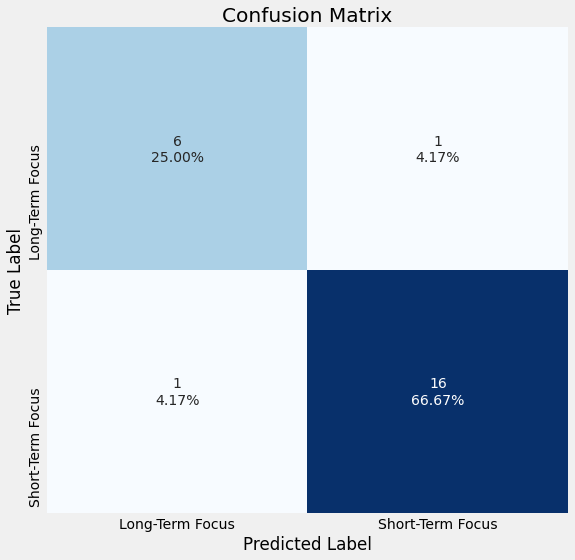

In [152]:
knn_sl = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,metric='euclidean',
                              n_neighbors=3,p=1,weights='distance')

run_model(knn_sl,Xsl_train,Xsl_test,ysl_train,ysl_test,sl_clusters)

## Collectivist vs. Individualist (C/N)

In [153]:
X_cn = cn_df.values
scaler = StandardScaler()
X_cn = scaler.fit_transform(X_cn)

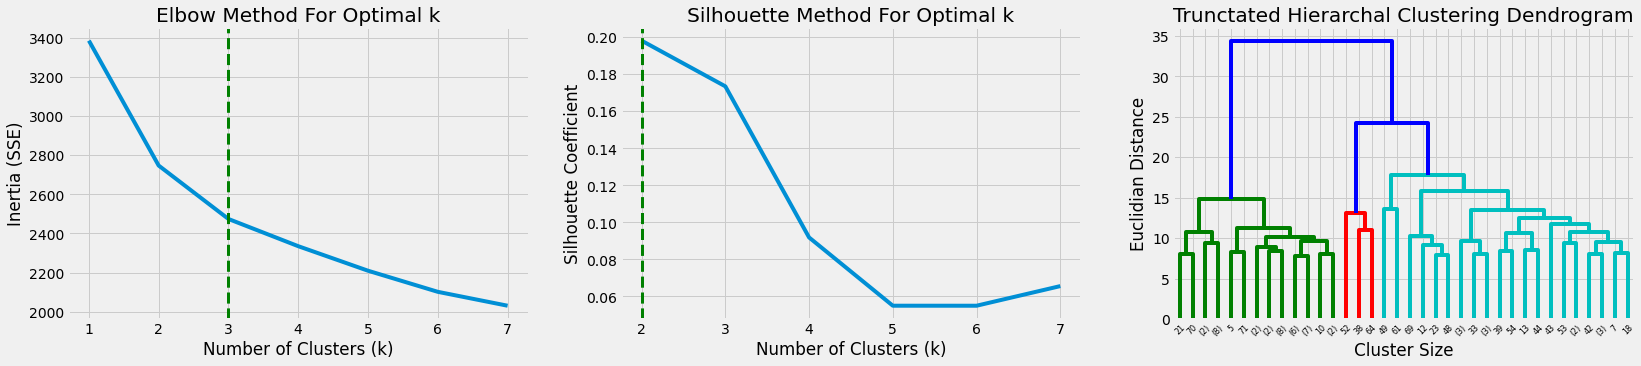

In [154]:
find_k(X_cn,1,round(len(cn_df)/10))

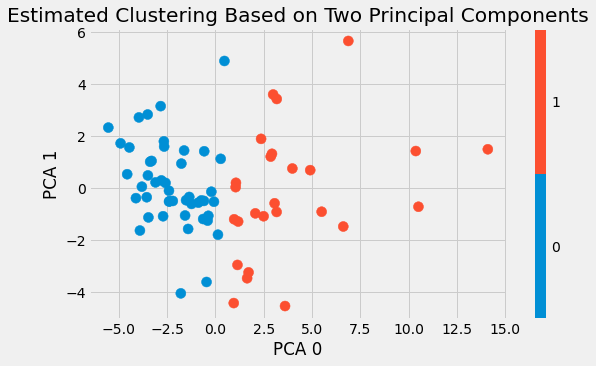

Explained variance ratio (first two components): [0.2959 0.0806]


Cluster 0  Cluster 1
0         46         26

In [155]:
cluster(X_cn, 2)

In [156]:
apply_clusters(X_cn, 2, "indiv", cn_df)

In [157]:
X = cn_df.drop(['indiv_cluster'], axis=1)
y = cn_df['indiv_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['RACE, GENDER, SEXUAL ORIENTATION:  [Our country has made the changes needed to give minorities equal rights]', 'EDUCATION:  [Education is an individual’s investment in themselves, therefore they should bare the cost, not the taxpayer]', 'JOBS & THE ECONOMY:  [Those who are able to work, and refuse the opportunity, should not expect society’s support]']


In [158]:
cn_df = cn_df[result]

X_cn = cn_df.values
scaler = StandardScaler()
X_cn = scaler.fit_transform(X_cn)

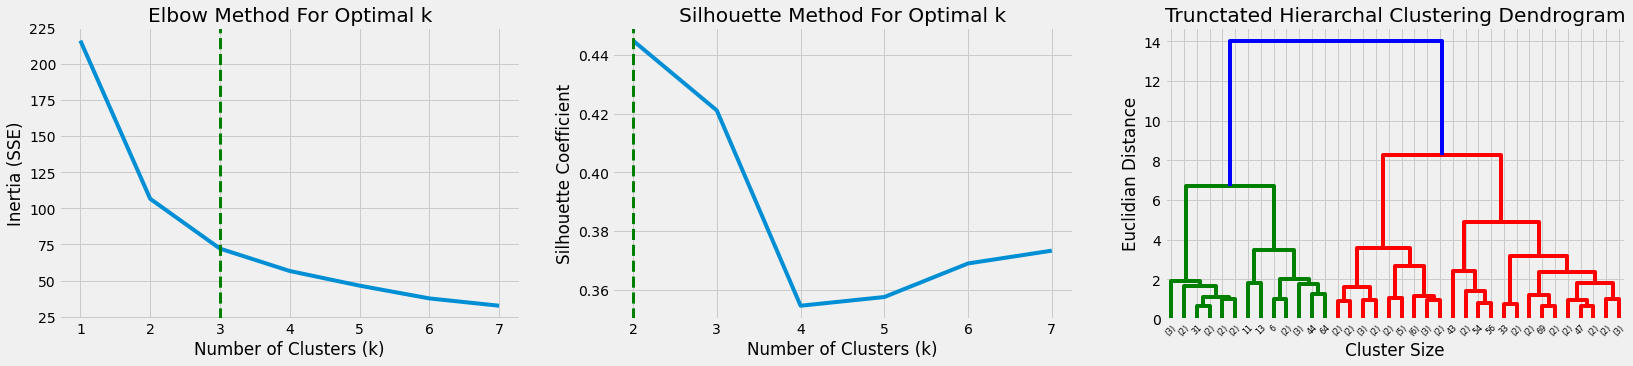

In [159]:
find_k(X_cn,1,round(len(cn_df)/10))

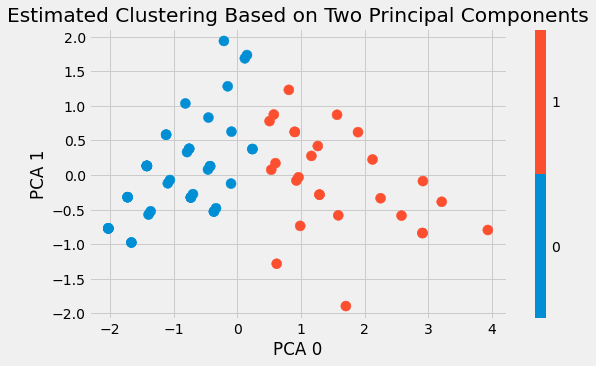

Explained variance ratio (first two components): [0.7089 0.1668]


Cluster 0  Cluster 1
0         45         27

In [160]:
cluster(X_cn, 2)

In [161]:
apply_clusters(X_cn, 2, "indiv", cn_df)

In [162]:
results = cn_df.groupby(['indiv_cluster']).median()
results

0              RACE, GENDER, SEXUAL ORIENTATION:  [Our country has made the changes needed to give minorities equal rights]  ...  JOBS & THE ECONOMY:  [Those who are able to work, and refuse the opportunity, should not expect society’s support]
indiv_cluster                                                                                                                ...                                                                                                                    
0                                                                                                                      -3.0  ...                                                                                                                -1.0
1                                                                                                                       1.0  ...                                                                                                                 2.0

[2 rows x 3 columns]


MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 89.58%
Training R-Squared:  0.8958333333333334
Training Root Mean Square Error 0.3227486121839514

Validation accuracy: 100.0%
Validation R-Squared:  1.0
Validation Root Mean Square Error: 0.0


CLASSIFICATION REPORT AND CONFUSION MATRIX
               precision    recall  f1-score   support

Individualist       1.00      1.00      1.00        16
 Collectivist       1.00      1.00      1.00         8

     accuracy                           1.00        24
    macro avg       1.00      1.00      1.00        24
 weighted avg       1.00      1.00      1.00        24



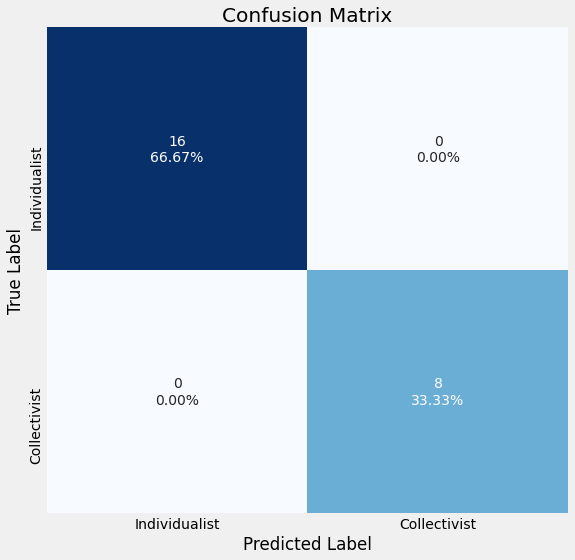

In [163]:
y_cn = cn_df['indiv_cluster']
Xcn_train, Xcn_test, ycn_train, ycn_test = train_test_split(X_cn, y_cn, test_size=0.33, random_state=10)

knn_cn = KNeighborsClassifier()
cn_clusters = ['Individualist','Collectivist']

run_model(knn_cn,Xcn_train,Xcn_test,ycn_train,ycn_test, cn_clusters)

In [164]:
#Parameter tuning with GridSearchCV 
grid_search_KNN.fit(Xcn_train, ycn_train)

#Find best parameters
best_parameters = grid_search_KNN.best_params_
print("Grid Search Found the Following Optimal Parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s=%r" % (param_name, best_parameters[param_name]))

Grid Search Found the Following Optimal Parameters: 
algorithm='ball_tree'
leaf_size=1
metric='chebyshev'
n_neighbors=1
p=1
weights='uniform'



MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='chebyshev',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=1,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 95.83%
Training R-Squared:  0.9583333333333334
Training Root Mean Square Error 0.2041241452319315

Validation accuracy: 95.83%
Validation R-Squared:  0.9583333333333334
Validation Root Mean Square Error: 0.2041241452319315


CLASSIFICATION REPORT AND CONFUSION MATRIX
               precision    recall  f1-score   support

Individualist       0.94      1.00      0.97        16
 Collectivist       1.00      0.88      0.93         8

     accuracy                           0.96        24
    macro avg       0.97      0.94      0.95        24
 weighted avg       0.96      0.96      0.96        24



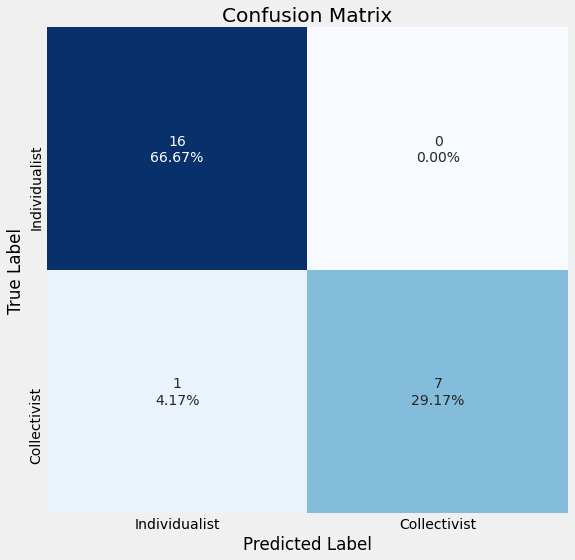

In [165]:
knn_cn = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,metric='chebyshev',
                              n_neighbors=9,p=1)

run_model(knn_cn,Xcn_train,Xcn_test,ycn_train,ycn_test, cn_clusters)

##Relativist vs. Absolutist (R/B)

In [166]:
X_rb = rb_df.values
scaler = StandardScaler()
X_rb = scaler.fit_transform(X_rb)

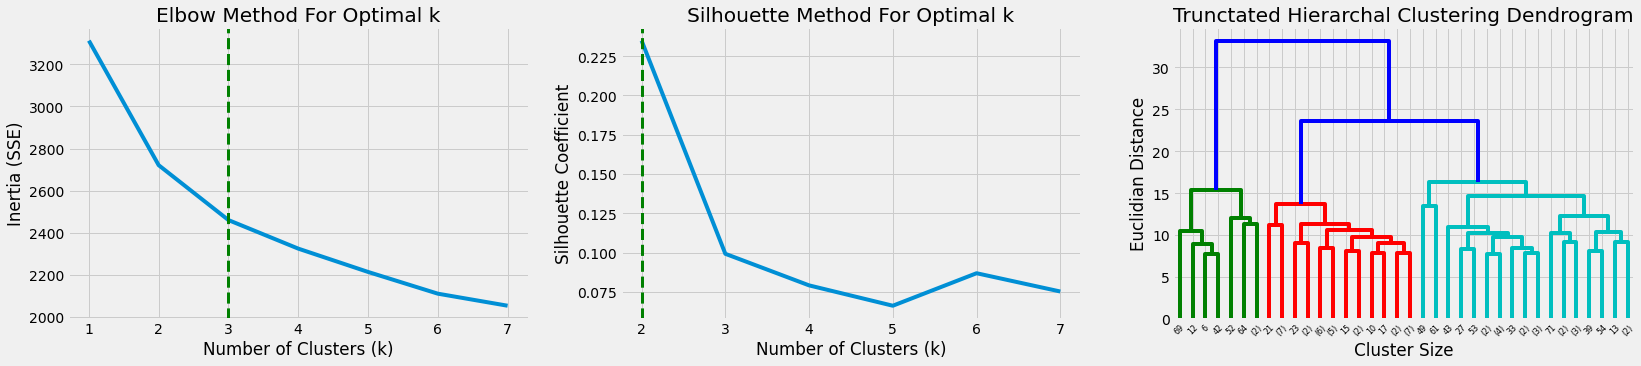

In [167]:
find_k(X_rb,1,round(len(rb_df)/10))

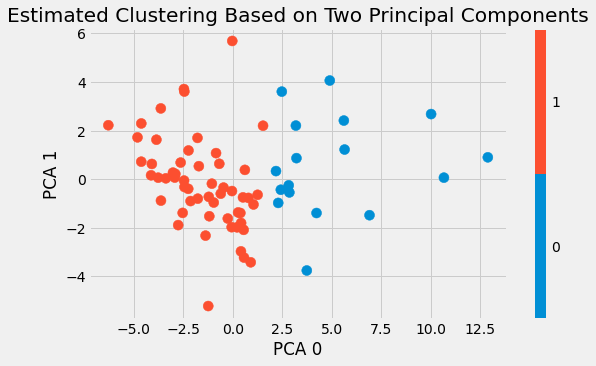

Explained variance ratio (first two components): [0.279  0.0805]


Cluster 0  Cluster 1
0         17         55

In [168]:
cluster(X_rb, 2)

In [169]:
apply_clusters(X_rb, 2, "relate", rb_df)

In [170]:
X = rb_df.drop(['relate_cluster'], axis=1)
y = rb_df['relate_cluster']

result = stepwise_selection(X,y, verbose=False)
print(result)

['HEALTH CARE:  [I support single-payer, universal health care]', 'RELIGION:  [My religious values should be spread as much as possible]', 'RACE, GENDER, SEXUAL ORIENTATION:  [Abortion, when the woman’s life is not threatened, should always be illegal]', 'JOBS & THE ECONOMY:  [The government should do more to help needy citizens, even if it means going deeper into debt]']


In [171]:
rb_df = rb_df[result]

X_rb = rb_df.values
scaler = StandardScaler()
X_rb = scaler.fit_transform(X_rb)

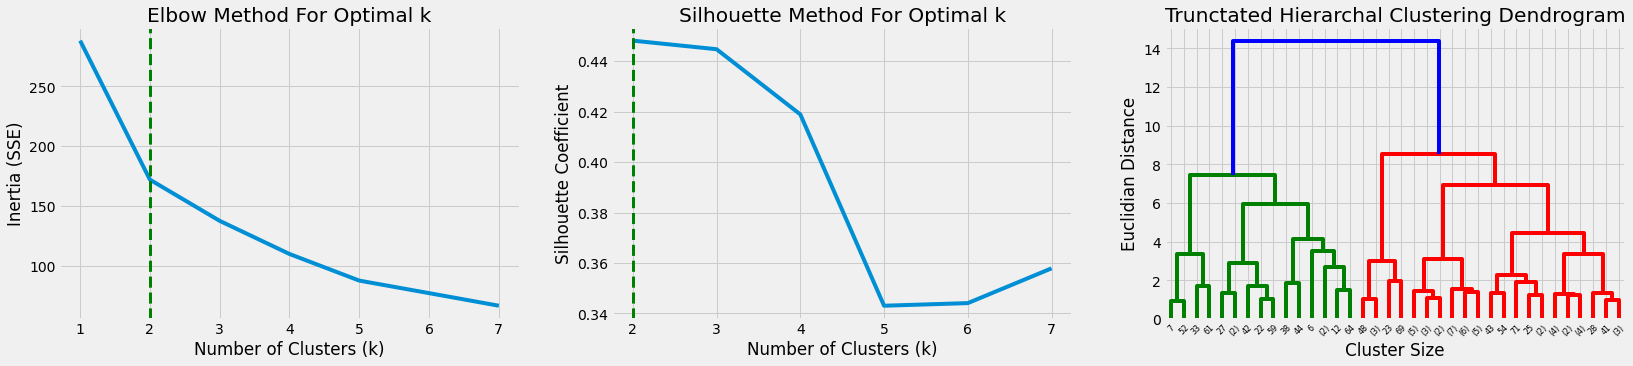

In [172]:
find_k(X_rb,1,round(len(rb_df)/10))

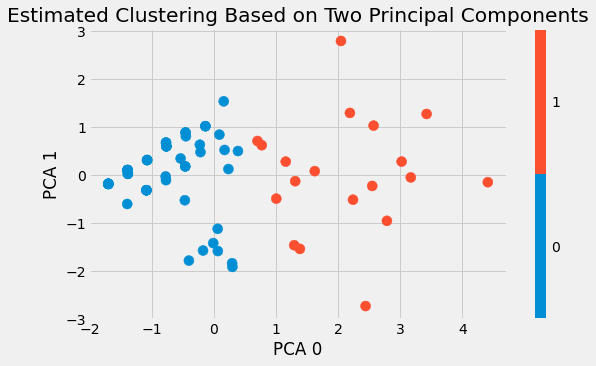

Explained variance ratio (first two components): [0.5366 0.2   ]


Cluster 0  Cluster 1
0         53         19

In [173]:
cluster(X_rb, 2)

In [174]:
apply_clusters(X_rb, 2, "relate", rb_df)

In [175]:
results = rb_df.groupby(['relate_cluster']).median()
results

0               HEALTH CARE:  [I support single-payer, universal health care]  ...  JOBS & THE ECONOMY:  [The government should do more to help needy citizens, even if it means going deeper into debt]
relate_cluster                                                                 ...                                                                                                                      
0                                                                         3.0  ...                                                                                                                   2.0
1                                                                         0.0  ...                                                                                                                  -1.0

[2 rows x 4 columns]


MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 100.0%
Validation R-Squared:  1.0
Validation Root Mean Square Error: 0.0


CLASSIFICATION REPORT AND CONFUSION MATRIX
              precision    recall  f1-score   support

  Absolutist       1.00      1.00      1.00        18
  Relativist       1.00      1.00      1.00         6

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



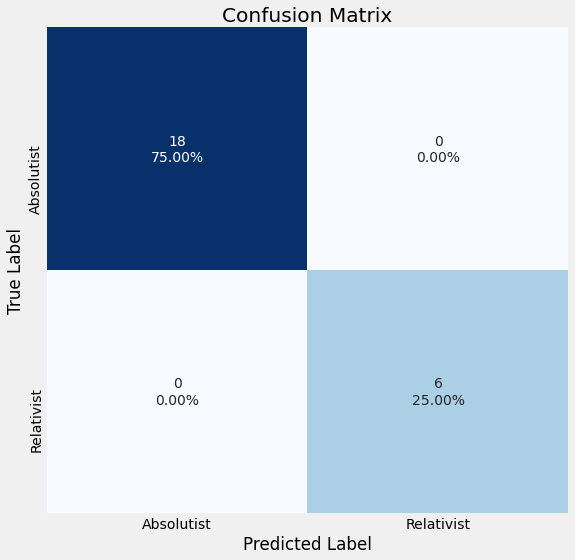

In [176]:
y_rb = rb_df['relate_cluster']
Xrb_train, Xrb_test, yrb_train, yrb_test = train_test_split(X_rb, y_rb, test_size=0.33, random_state=10)

knn_rb = KNeighborsClassifier()
rb_clusters = ['Absolutist','Relativist']

run_model(knn_rb,Xrb_train,Xrb_test,yrb_train,yrb_test, rb_clusters)

In [177]:
#Parameter tuning with GridSearchCV 
grid_search_KNN.fit(Xrb_train, yrb_train)

#Find best parameters
best_parameters = grid_search_KNN.best_params_
print("Grid Search Found the Following Optimal Parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s=%r" % (param_name, best_parameters[param_name]))

Grid Search Found the Following Optimal Parameters: 
algorithm='ball_tree'
leaf_size=1
metric='manhattan'
n_neighbors=5
p=1
weights='distance'



MODEL HYPERPARAMETERS
KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='uniform')


ACCURACY, R-SQUARED, AND ROOT MEAN SQUARED ERROR
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 95.83%
Validation R-Squared:  0.9583333333333334
Validation Root Mean Square Error: 0.2041241452319315


CLASSIFICATION REPORT AND CONFUSION MATRIX
              precision    recall  f1-score   support

  Absolutist       1.00      0.94      0.97        18
  Relativist       0.86      1.00      0.92         6

    accuracy                           0.96        24
   macro avg       0.93      0.97      0.95        24
weighted avg       0.96      0.96      0.96        24



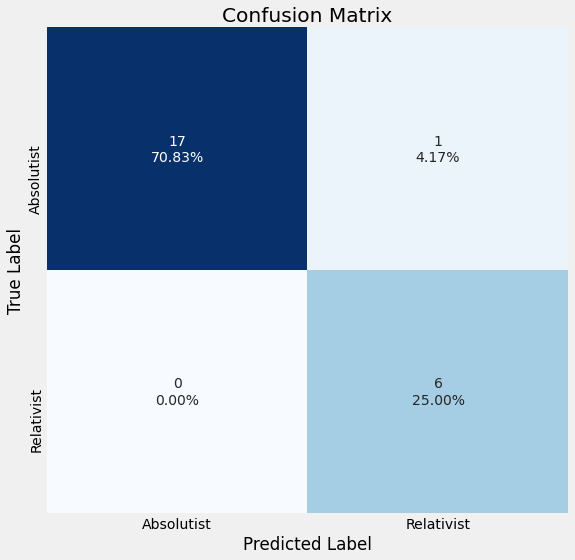

In [178]:
knn_rb = KNeighborsClassifier(algorithm='ball_tree',leaf_size=1,metric='euclidean',
                              n_neighbors=3,p=1)

run_model(knn_rb,Xrb_train,Xrb_test,yrb_train,yrb_test, rb_clusters)

#**Results**

In all, the decision-making clusters from psychology and ethics were a more reliable method for identifying what clusters a member might be a part of. A single survey response could drastically change the number of clusters visible in the political clusters, but by create a dichotomy, we instead could shift our analysis to how these clusters interacted.

In [179]:
final_df = df.iloc[:,75:]
final_df = final_df.rename(columns={'institutional_cluster':'Satisifaction/Status Quo','time_cluster':'Time Horizon',
                   'indiv_cluster':'Needs Priotization','relate_cluster':"Moral Purity"})
final_df.head()

0  Satisifaction/Status Quo  Time Horizon  Needs Priotization  Moral Purity
1                         0             1                   0             0
2                         0             0                   0             0
3                         0             1                   0             0
4                         0             1                   0             0
5                         0             1                   1             0

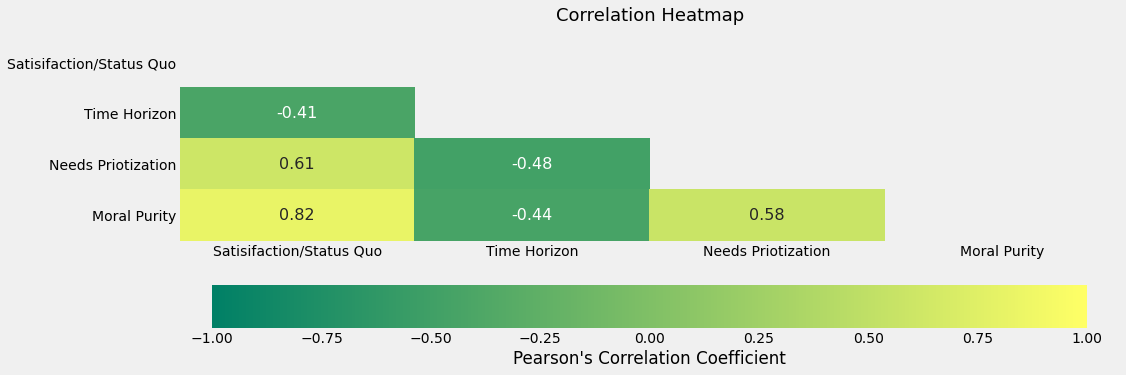

In [180]:
plt.figure(figsize=(15, 5))
mask = np.triu(final_df.corr())
heatmap = sns.heatmap(final_df.corr(),mask=mask,vmin=-1,vmax=1,annot=True,cmap='summer',
                      annot_kws={'size':16},cbar_kws={'label':"Pearson's Correlation Coefficient", 'orientation':'horizontal'})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.xlabel("")
plt.ylabel("");

Satisfaction with the Status Quo had strong correlation with Needs Prioritization (p = -.67) and Moral Purity (p = -.65).
* Institutionalists are more likely to be Individualists and Absolutists
* Anarchists are more likely to be Collectivists and Relativists.

<br>Further, political dimensions were distributed across decision-making dimensions. Further research should be conducted to see if there is an explicit relationship between decision-making clusters and political clusters.

# **Opportunities for Future Research**

**RE-EVALUATE & ITERATE WITH MORE RESPONDENTS**
<br>It was was not possible to make sound statistical conclusions for each hypothesis with the amount of data gathered thus far.<br><br>
**DEEPER ANALYSIS OF ALL DIMENSIONS**
<br>With the large amount of quantitative and text data gathered from each respondent, further research should be conducted to see if there are meaningful connections between political and decision-making dimensions.<br><br>
**LANGUAGE ANALYSIS OF FREE-FORM COMMENTS**
<br>There is considerable text data that could be used in an analysis of the rhetoric used by each decision-making dimension.